In [1]:
import numpy as np
import pandas as pd

# Plotting Packages
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as mtick

from sklearn import linear_model
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import seaborn as sns
from sklearn import preprocessing

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split

import scipy.stats as stats
from scipy.stats import shapiro

import warnings

In [2]:
# data = pd.read_csv('data/indicators_citations_bulk_df.csv')
# data = pd.read_csv('data/dist_calc_citations_bulk_df.csv')
# data = pd.read_csv('data/pc_change_citations_bulk_df.csv')
# income = pd.read_csv('data/wdi_incomelevels.csv')

# #all zeros for citations were dropped in building the data frame
# data['log_2_Years'] = np.log(data['2 years window'])

# #merge with income
# income['Country'] = income['Country'].str.lower()
# income = income.rename(columns={'Country': 'Country Name'})
# data = pd.merge(data, income, on=['Country Name'], how='left') 
# data.head()

### Functions for regressions with plots + assumption check

In [3]:
def unique(list1):

    unique_list = []
 
    for x in list1:
        if x not in unique_list:
            unique_list.append(x)
    return unique_list

In [4]:
def unique_list(list1, list2):

    unique_list = []
 
    for x in list1:
        if x not in list2:
            unique_list.append(x)
    return unique_list

In [5]:
def linear_regression_plot (x, y, x_name, y_name, data_name, xlabel, ylabel):

    x2 = sm.add_constant(x)
    X_train, X_test, y_train, y_test = train_test_split(x2, y, test_size = 0.3, random_state = 0)

    # Fit the simple linear regression
    sm_model = sm.OLS(y_train, X_train, missing='drop')
    results = sm_model.fit()

    # Make predictions using the linear regression
    y_pred_x2 = results.predict(x2)
    y_pred = results.predict(X_test)
    
    #extract p-value for specific predictor variable name
    p_val_x = results.pvalues.loc[x_name]
    
    not_sig_ind = []
    sig_ind = []
    resids_not_normal = []
    
#     yes = 'yes'
#     no = 'NA'
    
#     models_sig = pd.DataFrame(columns = ['predictor', 'indicator','significant','not_significant'])
    if p_val_x < 0.05:
        sig_ind = y_name
        yes = 'yes'
        no = 'NA'
        
#         new_row = {'predictor': x_name, 'indicator': y_name, 'significant': yes, 'not_significant' : no}
#         models_sig = models_sig.append(new_row, ignore_index = True)
        
        print(y_name+' vs '+x_name)
        # Plot 
        xtest = np.array(X_test.iloc[:,-1:])
        plt.figure(figsize=(15, 8), dpi=80)
        p1 = sns.scatterplot(x = x_name, y = y_name, data = data_name, hue='Economy Level', s=100)
        p1.legend(bbox_to_anchor=(1.01,1.0), loc='upper left', borderaxespad=0)#,borderaxespad = 0., ncol = 1)
        plt.plot(x, y_pred_x2, color='blue', linewidth=3)
        plt.plot(xtest, y_pred, color='red', linewidth=5)
        plt.xlabel(xlabel, fontsize=13)
        plt.ylabel(ylabel, fontsize=13)
        plt.title(ylabel +' vs. '+xlabel, fontsize=15)

        plt.show()
        
        
        print(results.summary())
        print('==============================================')
        
        
        #checking assumptions
        #plot residuals
        print()
        print("Residuals vs Fitted Values-- looking for heteroskedascity")
        resids = results.resid
#         y_pred = results.predict(X_train)
        fitted_vals = results.fittedvalues
        plt.scatter(fitted_vals, resids, color='black', alpha = 0.25)
#         plt.scatter(y_pred, resids,  color='black', alpha = 0.25)
        plt.xlabel('Fitted values')
        plt.ylabel('Residuals')
        plt.title('Residuals vs Fitted Values')
        plt.show()
        
        #qq plot for normality of residuals
        print('Residuals-- checking normality')
        sm.qqplot(resids, line='s') #get p values
        plt.show()
        
        #shirpo-wilks test for residuals normality
#         print("If p-value < 0.05, residuals are not normal")
#         print(shapiro(resids)[1])
        
        if shapiro(resids)[1] < 0.05:
            print('Residuals are not normal')
            
            resids_not_normal = y_name
        
        print('=========================================================================================')
        
#         #histograms
#         #hist for x
#         print()
#         print('Histogram for '+x_name)
#         plt.hist(x)
#         plt.xlabel(xlabel, fontsize=13)
#         plt.title('Histogram for '+xlabel, fontsize=15)
#         plt.show()
        
# #         #hist for y
# #         print()
# #         print('Histogram for '+y_name)
# #         plt.hist(y)
# #         plt.xlabel(ylabel, fontsize=13)
# #         plt.title('Histogram for '+ylabel, fontsize=15)
# #         plt.show()
    
    else:
        not_sig_ind = y_name
    
    print('=========================================================================================')
    
    return sig_ind, not_sig_ind, resids_not_normal

https://stackoverflow.com/questions/55246295/patsyerror-error-evaluating-factor-nameerror
https://www.statsmodels.org/dev/examples/notebooks/generated/quantile_regression.html
https://www.statsmodels.org/dev/generated/statsmodels.regression.quantile_regression.QuantRegResults.html

#geeks for geeks quantile regression

http://inversionlabs.com/2016/02/07/using-quantile-regression.html

In [6]:
def confidence_interval(X, y, y_pred):
    # Covariance of coefficient estimates
    mse = np.sum(np.square(y_pred - y)) / y.size
#     print(mse.shape)
    cov = mse * np.linalg.inv(X.T @ X)
    # Alternatively the covariance could be found using StatsModels:
#     cov = model.cov_params()
#     print(cov.shape)

    # Calculate variance of f(x)
    var_f = np.diagonal((X @ cov) @ X.T)

    # Derive standard error of f(x) from variance
    se       = np.sqrt(abs(var_f))
    conf_int = 2*se

    return conf_int

In [7]:
def quantile_regression_plot (x, y, x_name, y_name, data_name, xlabel, ylabel, quantile):

    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)
    
#     df = data_name[[x_name,y_name]]
    df = pd.concat([X_train,y_train],axis='columns')

    # Fit the quantile regression
    equation = y_name+' ~ '+x_name
    mod = smf.quantreg(equation, df)
    results = mod.fit(q=quantile)
    
    not_sig_ind = []
    sig_ind = []
    resids_not_normal = []
    
    if results.pvalues[1] < 0.05:
        sig_ind = y_name
        yes = 'yes'
        no = 'NA'

        print(y_name+' vs '+x_name)
        # Plot 
        # define figure and axis
#         fig, ax = plt.subplots(figsize=(8, 6))

        # get y values
        y_line = lambda a, b: a + x
        y = y_line(results.params['Intercept'],
                   results.params[x_name])
        
        #get prediction
        y_pred_test = results.predict(pd.DataFrame(X_test))
        y_pred_train = results.predict(pd.DataFrame(X_train))
        
        CI = stats.t.interval(alpha=0.95,df=len(X_train)-1,
              loc=np.mean(X_train),
              scale=stats.sem(X_train))

        # Plotting data points with the help
        # pf quantile regression equation
#         ax.plot(x, y, color='black')
#         ax.scatter(x, y, alpha=.3)
#         ax.set_xlabel(x_name, fontsize=20)
#         ax.set_ylabel(y_name, fontsize=20)
#         xtest = np.array(X_test.iloc[:,-1:])

        plt.figure(figsize=(15, 8), dpi=80)
        p1 = sns.scatterplot(x = x_name, y = y_name, data = data_name, hue= 'Economy Level', s=100, alpha=0.5)
        p1.legend(bbox_to_anchor=(1.01,1.0), loc='upper left', borderaxespad=0)#,borderaxespad = 0., ncol = 1)
#         plt.plot(x, y, color='red', linewidth=3)
        plt.plot(X_train, y_pred_train, color='blue', linewidth=3)
        plt.plot(X_test, y_pred_test, color='blue', linewidth=3)
#         plt.fill_between(X_train, y_pred_train-conf_int, y_pred_train+conf_int, facecolor = 'm', alpha = 0.5)
#         plt.fill_between(X_train, CI[0],CI[1], facecolor = 'm', alpha = 0.5)
        plt.xlabel(xlabel, fontsize=13)
        plt.ylabel(ylabel, fontsize=13)
        plt.title(ylabel +' vs. '+xlabel, fontsize=15)

        plt.show()

        
        
        print(results.summary())
        print('==============================================')
        
        
        #checking assumptions
        #plot residuals
        print()
        print("Residuals vs Fitted Values-- looking for heteroskedascity")
        resids = results.resid
# #         y_pred = results.predict(X_train)
        fitted_vals = results.fittedvalues
        plt.scatter(fitted_vals, resids, color='black', alpha = 0.25)
# #         plt.scatter(y_pred, resids,  color='black', alpha = 0.25)
        plt.xlabel('Fitted values')
        plt.ylabel('Residuals')
        plt.title('Residuals vs Fitted Values')
        plt.show()
        
#         #qq plot for normality of residuals
        print('Residuals-- checking normality')
        sm.qqplot(resids, line='s') #get p values
        plt.show()
        
        
        if shapiro(resids)[1] < 0.05:
            print('Residuals are not normal')
            
            resids_not_normal = y_name
        
        print('=========================================================================================')
    
    else:
        not_sig_ind = y_name
    
    print('=========================================================================================')
    
    return sig_ind, not_sig_ind, resids_not_normal

In [8]:
# def QR_cv_with_CI(x, y, x_name, y_name, data_name, xlabel, ylabel, quantile):

#     df = data_name[[x_name,y_name]]
#     mses = pd.DataFrame()
#     fold = 0

#     kf = KFold(n_splits=5, shuffle=True, random_state=0) 
#     for train_index, val_index in kf.split(df):
#         # Separate each array into respective variables
#         df_train = np.asarray(df)[train_index]
#         df_train = pd.DataFrame(df_train, columns = df.columns)
#         df_val = np.asarray(df)[val_index]
#         df_val = pd.DataFrame(df_val, columns = df.columns)
        
#         X_train = df_train[[x_name]]
#         X_val = df_val[[x_name]]
    
#         # Calculate the MSE for each fold
#         MSE_array = []
        
#         # Fit the quantile regression
#         equation = y_name+' ~ '+x_name
#         mod = smf.quantreg(equation, df_train)
#         results = mod.fit(q=quantile)
#         y_pred = results.predict(pd.DataFrame(X_val))

# #         # Fit linear regression model
# #         model = sm.OLS(df_train.solar_install, X_train).fit(disp=0)
# #         y_pred = model.predict(X_val)

            
# #         MSE = mean_squared_error(df_val[y_name], y_pred) #y_true, y_pred on validation set
#         y_true = df_val[y_name]
#         MSE = np.square(np.subtract(y_true,y_pred)).mean()
#         MSE_array.append(MSE)

#         mses[fold] = MSE_array
#         fold = fold+1

#     # Average the MSE across folds
#     mses['mses_ave'] = mses.mean(axis=1)

#     # Determine the minimum average MSE and the polynomial order where it occurs
#     MSE_ave_min = min(mses.mses_ave)
    
#     #confidence interval

#     df = df.dropna(subset=[y_name])
#     X = df[[x_name]]
#     y = df[[y_name]]
# #     print(y.shape)
# #     print(X.shape)
#     equation = y_name+' ~ '+x_name
#     mod = smf.quantreg(equation, df)
#     results = mod.fit(q=quantile)
    
#     not_sig_ind = []
#     sig_ind = []
#     resids_not_normal = []
    
#     if results.pvalues[1] < 0.05:
        
#         sig_ind = y_name
#         yes = 'yes'
#         no = 'NA'
        
#         y_pred_all = results.predict(pd.DataFrame(X))

#         X_reshape = np.array(X).reshape(-1, 1)
#         y_reshape = np.array(y).reshape(-1, 1)
#         y_pred_all_reshape = np.array(y_pred_all).reshape(-1, 1)

#         conf_int = confidence_interval(X_reshape, y_reshape, y_pred_all_reshape)
        
#         print(y_name+' vs '+x_name)

#         plt.figure(figsize=(15, 8), dpi=80)
#         hue_order = ['High-Income', 'Upper-Middle Income', 'Lower-Middle Income', 'Low-Income']
#         p1 = sns.scatterplot(x = x_name, y = y_name, data = data_name, hue= 'Economy Level', hue_order=hue_order,s=100, alpha=0.5)
#         p1.legend(bbox_to_anchor=(1.01,1.0), loc='upper left', borderaxespad=0)

#         data_name = data_name.dropna(subset=[y_name])
#         plt.plot(data_name[x_name], y_pred_all, 'm')
#         plt.fill_between(data_name[x_name], y_pred_all-conf_int, y_pred_all+conf_int, facecolor = 'm', alpha = 0.5)
#         plt.xlabel(xlabel, fontsize=13)
#         plt.ylabel(ylabel, fontsize=13)
#         plt.title(ylabel +' vs. '+xlabel, fontsize=15)
#         plt.show()
        
#         print('Average validation MSE over 5 folds: ',MSE_ave_min)
#         print()
        
#         print(results.summary())
#         print('======================================================================================')
#         print()


#     #     plt.figure(figsize=(15, 8), dpi=80)
#     #     p1 = sns.scatterplot(x = x_name, y = y_name, data = data_name, hue= 'Economy Level', s=100, alpha=0.5)
#     #     p1.legend(bbox_to_anchor=(1.01,1.0), loc='upper left', borderaxespad=0)#,borderaxespad = 0., ncol = 1)
#     # #         plt.plot(x, y, color='m', linewidth=3)
#     # #         plt.plot(X_train, y_pred_train, color='blue', linewidth=3)
#     #     plt.plot(X_test, y_pred_test, color='m', linewidth=3)
#     # #         plt.fill_between(X_train, y_pred_train-conf_int_train, y_pred_train+conf_int_train, facecolor = 'm', alpha = 0.5)
#     # #         plt.fill_between(X_test, y_pred_test-conf_int_test, y_pred_test+conf_int_test, facecolor = 'm', alpha = 0.5)
#     # #         plt.fill_between(x, y_pred-conf_int, y_pred+conf_int, facecolor = 'm', alpha = 0.5)
#     #     plt.xlabel(xlabel, fontsize=13)
#     #     plt.ylabel(ylabel, fontsize=13)
#     #     plt.title(ylabel +' vs. '+xlabel, fontsize=15)

#     #     plt.show()
#     else:
#         not_sig_ind = y_name
    
#     print('=========================================================================================')
#     print()

#     return sig_ind, not_sig_ind

In [36]:
def QR_cv_with_CI(x, y, x_name, y_name, data_name, xlabel, ylabel, quantile):

    df = data_name[[x_name,y_name]]
    mses = pd.DataFrame()
    fold = 0

    kf = KFold(n_splits=5, shuffle=True, random_state=0) 
    for train_index, val_index in kf.split(df):
        # Separate each array into respective variables
        df_train = np.asarray(df)[train_index]
        df_train = pd.DataFrame(df_train, columns = df.columns)
        df_val = np.asarray(df)[val_index]
        df_val = pd.DataFrame(df_val, columns = df.columns)
        
        X_train = df_train[[x_name]]
        X_val = df_val[[x_name]]
    
        # Calculate the MSE for each fold
        MSE_array = []
        
        # Fit the quantile regression
        equation = y_name+' ~ '+x_name
        mod = smf.quantreg(equation, df_train)
        results = mod.fit(q=quantile)
        y_pred = results.predict(pd.DataFrame(X_val))

#         # Fit linear regression model
#         model = sm.OLS(df_train.solar_install, X_train).fit(disp=0)
#         y_pred = model.predict(X_val)

            
#         MSE = mean_squared_error(df_val[y_name], y_pred) #y_true, y_pred on validation set
        y_true = df_val[y_name]
        MSE = np.square(np.subtract(y_true,y_pred)).mean()
        MSE_array.append(MSE)

        mses[fold] = MSE_array
        fold = fold+1

    # Average the MSE across folds
    mses['mses_ave'] = mses.mean(axis=1)

    # Determine the minimum average MSE and the polynomial order where it occurs
    MSE_ave_min = min(mses.mses_ave)
    
    #confidence interval

    df = df.dropna(subset=[y_name])
    X = df[[x_name]]
    y = df[[y_name]]
#     print(y.shape)
#     print(X.shape)
    equation = y_name+' ~ '+x_name
    mod = smf.quantreg(equation, df)
    results = mod.fit(q=quantile)
    
    not_sig_ind = []
    sig_ind = []
    resids_not_normal = []
    
    if results.pvalues[1] < 0.05:
        
        sig_ind = y_name
        yes = 'yes'
        no = 'NA'
        
        y_pred_all = results.predict(pd.DataFrame(X))

        X_reshape = np.array(X).reshape(-1, 1)
        y_reshape = np.array(y).reshape(-1, 1)
        y_pred_all_reshape = np.array(y_pred_all).reshape(-1, 1)

        conf_int = confidence_interval(X_reshape, y_reshape, y_pred_all_reshape)
        
        print(y_name+' vs '+x_name)

        plt.figure(figsize=(15, 8), dpi=80)
        hue_order = ['High-Income', 'Upper-Middle Income', 'Lower-Middle Income', 'Low-Income']
        p1 = sns.scatterplot(x = x_name, y = y_name, data = data_name, hue= 'Economy Level', hue_order=hue_order,s=100, alpha=0.5)
        
#         p1 = sns.scatterplot(x = x_name, y = y_name, data = data_name, hue= 'Economy Level', s=100, alpha=0.5)
        p1.legend(bbox_to_anchor=(1.01,1.0), loc='upper left', borderaxespad=0)

        data_name = data_name.dropna(subset=[y_name])
        plt.plot(data_name[x_name], y_pred_all, 'm')
        plt.fill_between(data_name[x_name], y_pred_all-conf_int, y_pred_all+conf_int, facecolor = 'm', alpha = 0.5)
        plt.xlabel(xlabel, fontsize=13)
        plt.ylabel(ylabel, fontsize=13)
        plt.title(ylabel +' vs. '+xlabel, fontsize=15)
        plt.show()
        
        print('Average validation MSE over 5 folds: ',MSE_ave_min)
        print()
        
        print(results.summary())
        print('======================================================================================')
        print()


    #     plt.figure(figsize=(15, 8), dpi=80)
    #     p1 = sns.scatterplot(x = x_name, y = y_name, data = data_name, hue= 'Economy Level', s=100, alpha=0.5)
    #     p1.legend(bbox_to_anchor=(1.01,1.0), loc='upper left', borderaxespad=0)#,borderaxespad = 0., ncol = 1)
    # #         plt.plot(x, y, color='m', linewidth=3)
    # #         plt.plot(X_train, y_pred_train, color='blue', linewidth=3)
    #     plt.plot(X_test, y_pred_test, color='m', linewidth=3)
    # #         plt.fill_between(X_train, y_pred_train-conf_int_train, y_pred_train+conf_int_train, facecolor = 'm', alpha = 0.5)
    # #         plt.fill_between(X_test, y_pred_test-conf_int_test, y_pred_test+conf_int_test, facecolor = 'm', alpha = 0.5)
    # #         plt.fill_between(x, y_pred-conf_int, y_pred+conf_int, facecolor = 'm', alpha = 0.5)
    #     plt.xlabel(xlabel, fontsize=13)
    #     plt.ylabel(ylabel, fontsize=13)
    #     plt.title(ylabel +' vs. '+xlabel, fontsize=15)

    #     plt.show()
    else:
        not_sig_ind = y_name
    
    print('=========================================================================================')
    print()

    return sig_ind, not_sig_ind

# Regressions for with % change of indicators

- Only significant regressions and assumptions are printed 

In [37]:
# data = pd.read_csv('data/indicators_citations_bulk_df.csv')
# data = pd.read_csv('data/dist_calc_citations_bulk_df.csv') 
# data = pd.read_csv('data/pc_change_citations_bulk_df.csv')
pd.set_option('display.max_columns', None)
data = pd.read_csv('data/pc_change_citations_ca_df.csv')
cols = data.columns[0]
data = data.drop(columns = cols)
income = pd.read_csv('data/wdi_incomelevels.csv')

#all zeros for citations were dropped in building the data frame
data['log_2_Years'] = np.log(data['2 years window'])

#merge with income
income['Country'] = income['Country'].str.lower()
income = income.rename(columns={'Country': 'Country Name'})
data = pd.merge(data, income, on=['Country Name'], how='left') 

#change column names to prevent patsy error issue with quantile regression
data = data.rename(columns={'electricy': 'electricity'})
data = data.rename(columns={'urban_electricy': 'urban_electricity'})
data = data.rename(columns={'rural_electricy': 'rural_electricity'})
data = data.rename(columns={'electric_from_renuable': 'electric_from_renewable'})
data = data.rename(columns={'energy_use(kg/capita)': 'energy_use_kg_capita'})
data = data.rename(columns={'energy_use(kg/kGDP)': 'energy_use_kg_kgdp'})
data = data.rename(columns={'GDP/Energy(constrant_2017)': 'gdp_over_energy_const_2017'})
data = data.rename(columns={'fossil_fual_comsumption': 'fossil_fuel_consumption'}) 
data = data.rename(columns={'renewable_comsumption': 'renewable_consumption'}) 
data = data.rename(columns={'GDP/Energy': 'gdp_over_energy'})

data = data.rename(columns={'combustiable_renewable_waste': 'combustible_renewable_waste'})
data = data.rename(columns={'hydroeletric': 'hydroelectric'})
data = data.rename(columns={'natrual_gas': 'natural_gas'})
data = data.rename(columns={'electric_from_renuable_kwh': 'electric_from_renewable_kwh'})

data = data.rename(columns={'ar index ca': 'ar_index_ca'})

data.head(4)

Year    Country Name  2 years window  ar_index_ca  cooking  rural_cooking  \
0  1991           india             1.0     0.707107      NaN            NaN   
1  1991  united kingdom             5.0     0.516398      NaN            NaN   
2  1992          brazil             2.0     0.454859      NaN            NaN   
3  1994           china             1.0     0.192450      NaN            NaN   

   urban_cooking  electricity  rural_electricity  urban_electricity  \
0            NaN          NaN                NaN                NaN   
1            NaN          NaN                NaN                NaN   
2            NaN          NaN                NaN                NaN   
3            NaN          NaN                NaN                NaN   

   nuclear_energy  combustible_renewable_waste  electric_consumption  \
0             NaN                          NaN                   NaN   
1             NaN                          NaN                   NaN   
2             NaN                          NaN                   NaN   
3             NaN                          NaN                   NaN   

   eletric_loss  coal  hydroelectric  natural_gas  nuclear  oil  oil_gas_coal  \
0           NaN   NaN            NaN          NaN      NaN  NaN           NaN   
1           NaN   NaN            NaN          NaN      NaN  NaN           NaN   
2           NaN   NaN            NaN          NaN      NaN  NaN           NaN   
3           NaN   NaN            NaN          NaN      NaN  NaN           NaN   

   electric_from_renewable  electric_from_renewable_kwh  energy_import  \
0                      NaN                          NaN            NaN   
1                      NaN                          NaN            NaN   
2                      NaN                          NaN            NaN   
3                      NaN                          NaN            NaN   

   energy_intensity  energy_use_kg_capita  energy_use_kg_kgdp  \
0               NaN                   NaN                 NaN   
1               NaN                   NaN                 NaN   
2               NaN                   NaN                 NaN   
3               NaN                   NaN                 NaN   

   fossil_fuel_consumption  gdp_over_energy_const_2017  gdp_over_energy  \
0                      NaN                         NaN              NaN   
1                      NaN                         NaN              NaN   
2                      NaN                         NaN              NaN   
3                      NaN                         NaN              NaN   

   renewable_output  renewable_consumption  log_2_Years        Economy Level  
0               NaN                    NaN     0.000000  Lower-Middle Income  
1               NaN                    NaN     1.609438          High-Income  
2               NaN                    NaN     0.693147  Upper-Middle Income  
3               NaN                    NaN     0.000000  Upper-Middle Income

### Simple Linear Regressions

#### - log_2_years

electric_consumption vs log_2_Years


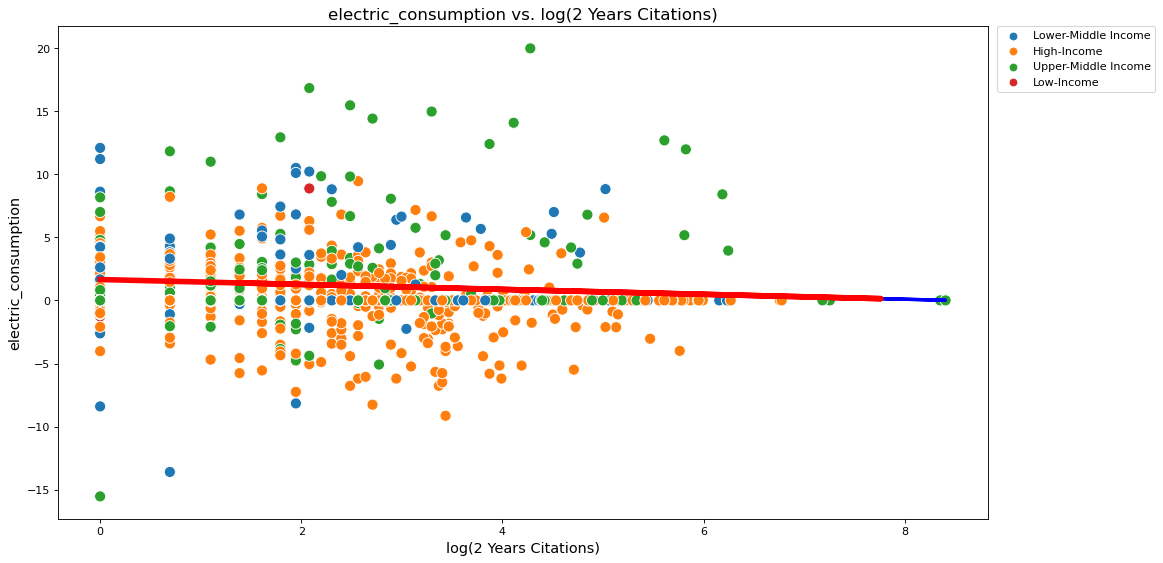

                             OLS Regression Results                             
Dep. Variable:     electric_consumption   R-squared:                       0.007
Model:                              OLS   Adj. R-squared:                  0.005
Method:                   Least Squares   F-statistic:                     3.887
Date:                  Thu, 22 Dec 2022   Prob (F-statistic):             0.0492
Time:                          05:55:23   Log-Likelihood:                -1449.1
No. Observations:                   534   AIC:                             2902.
Df Residuals:                       532   BIC:                             2911.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.6534      0.

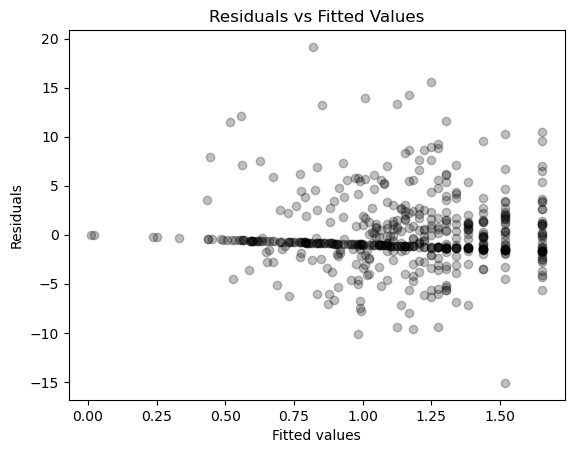

Residuals-- checking normality


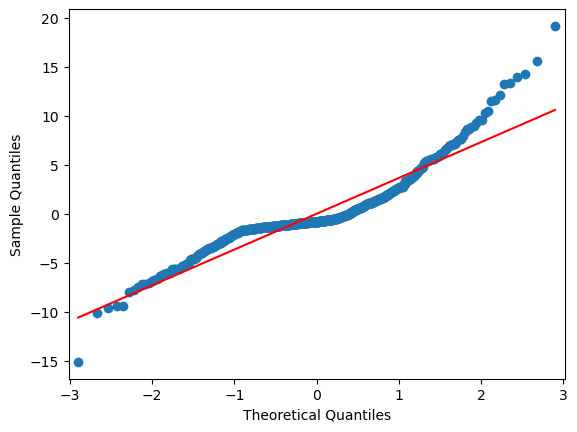

Residuals are not normal
gdp_over_energy vs log_2_Years


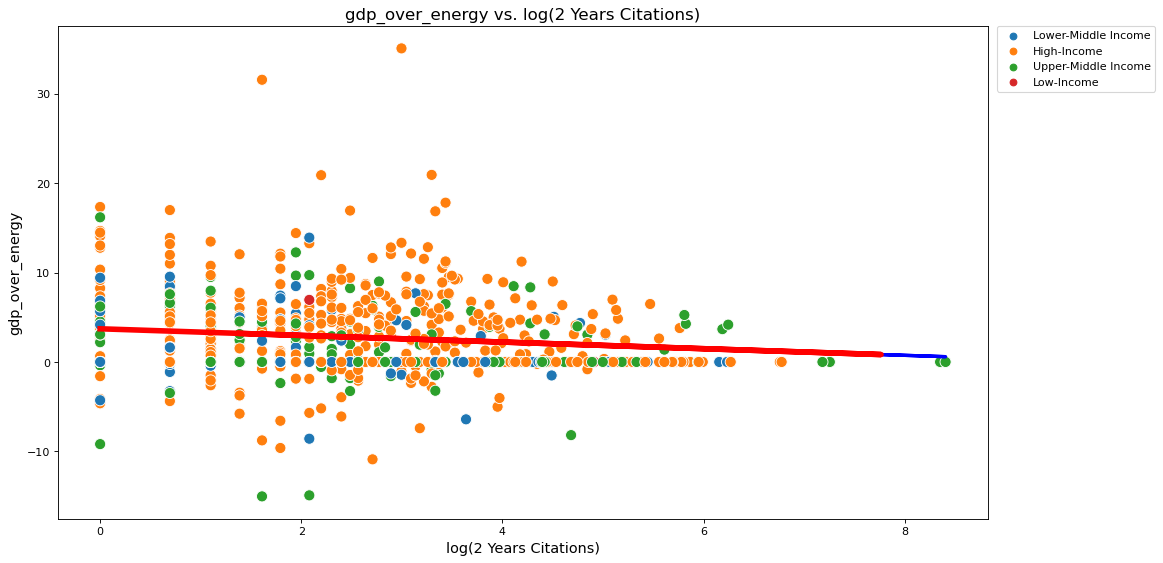

                            OLS Regression Results                            
Dep. Variable:        gdp_over_energy   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     8.592
Date:                Thu, 22 Dec 2022   Prob (F-statistic):            0.00352
Time:                        05:55:23   Log-Likelihood:                -1575.5
No. Observations:                 533   AIC:                             3155.
Df Residuals:                     531   BIC:                             3164.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           3.7072      0.389      9.535      

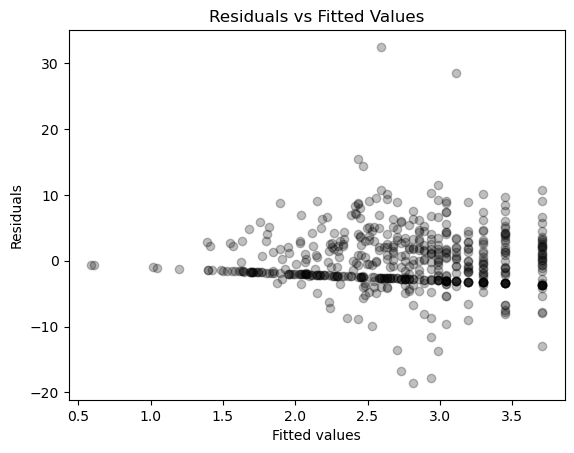

Residuals-- checking normality


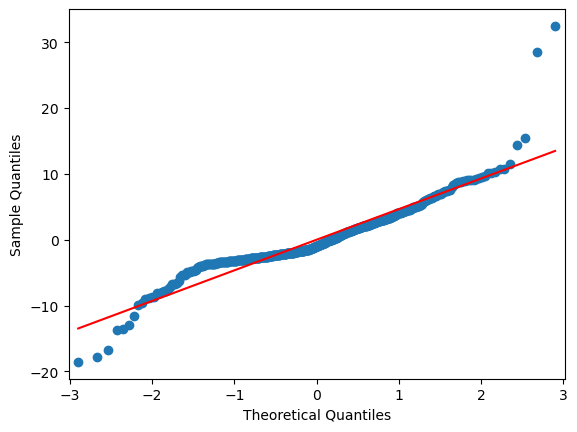

Residuals are not normal
Significant regression for:  [[], [], [], [], [], [], [], [], 'electric_consumption', [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], 'gdp_over_energy', [], []]

Not significant regression for:  ['cooking', 'rural_cooking', 'urban_cooking', 'electricity', 'rural_electricity', 'urban_electricity', 'nuclear_energy', 'combustible_renewable_waste', [], 'eletric_loss', 'coal', 'hydroelectric', 'natural_gas', 'nuclear', 'oil', 'oil_gas_coal', 'electric_from_renewable', 'electric_from_renewable_kwh', 'energy_import', 'energy_intensity', 'energy_use_kg_capita', 'energy_use_kg_kgdp', 'fossil_fuel_consumption', 'gdp_over_energy_const_2017', [], 'renewable_output', 'renewable_consumption']

Residuals are not normal when the following indicators are plotted against log(2 years) [[], [], [], [], [], [], [], [], 'electric_consumption', [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], 'gdp_over_energy', [], []]


In [38]:
warnings.filterwarnings("ignore")
indicators = data.columns.tolist()[4:31] #needs to be changed according to df
significant = []
not_significant = []
resid_not_norm_y = []

for i in indicators:
    temp_df = data[['Year', 'Country Name', '2 years window', 'log_2_Years', 'Economy Level',i]]
    temp_df['log_2_Years'] = temp_df['log_2_Years'].astype(float)
    
    x_2_yrs_log = temp_df['log_2_Years']
    y_ind = temp_df[i]
    

    sig, not_sig, resids_not_normal = linear_regression_plot(x_2_yrs_log, y_ind, 'log_2_Years', i, temp_df, 'log(2 Years Citations)', i)
    significant.append(sig)
    not_significant.append(not_sig)
    resid_not_norm_y.append(resids_not_normal)

print('Significant regression for: ',significant)
print()
print('Not significant regression for: ',not_significant)
print()
print('Residuals are not normal when the following indicators are plotted against log(2 years)', resid_not_norm_y)
warnings.filterwarnings("default")

In [39]:
if len(significant) - len(resid_not_norm_y) == 0:
    print("Residuals are not normal for any of the significant regressions")

Residuals are not normal for any of the significant regressions


##### Storing results in dataframe

In [40]:
significant_ind = [value for value in significant if value != []] 
val = len(significant_ind)

predictor = []
for i in range(val):
   predictor.append('log_2_years') 


is_significant = []
for i in range(val):
   is_significant.append('Yes') 

# is_not_significant = []
# for i in range(val):
#    is_not_significant.append('NA') 

models_sig = pd.DataFrame(list(zip(predictor, significant_ind, is_significant)),
               columns =['predictor','indicator', 'is_significant'])


not_significant_ind = [value for value in not_significant if value != []]
val = len(not_significant_ind)

predictor = []
for i in range(val):
   predictor.append('log_2_years') 


is_significant = []
for i in range(val):
   is_significant.append('No') 

# is_not_significant = []
# for i in range(val):
#    is_not_significant.append('yes') 

models_not_sig = pd.DataFrame(list(zip(predictor, not_significant_ind, is_significant)),
               columns =['predictor','indicator', 'is_significant'])

models = pd.concat([models_sig, models_not_sig],axis=0,ignore_index=True)
models

predictor                    indicator is_significant
0   log_2_years         electric_consumption            Yes
1   log_2_years              gdp_over_energy            Yes
2   log_2_years                      cooking             No
3   log_2_years                rural_cooking             No
4   log_2_years                urban_cooking             No
5   log_2_years                  electricity             No
6   log_2_years            rural_electricity             No
7   log_2_years            urban_electricity             No
8   log_2_years               nuclear_energy             No
9   log_2_years  combustible_renewable_waste             No
10  log_2_years                 eletric_loss             No
11  log_2_years                         coal             No
12  log_2_years                hydroelectric             No
13  log_2_years                  natural_gas             No
14  log_2_years                      nuclear             No
15  log_2_years                          oil             No
16  log_2_years                 oil_gas_coal             No
17  log_2_years      electric_from_renewable             No
18  log_2_years  electric_from_renewable_kwh             No
19  log_2_years                energy_import             No
20  log_2_years             energy_intensity             No
21  log_2_years         energy_use_kg_capita             No
22  log_2_years           energy_use_kg_kgdp             No
23  log_2_years      fossil_fuel_consumption             No
24  log_2_years   gdp_over_energy_const_2017             No
25  log_2_years             renewable_output             No
26  log_2_years        renewable_consumption             No

#### - AR-index

rural_cooking vs ar_index_ca


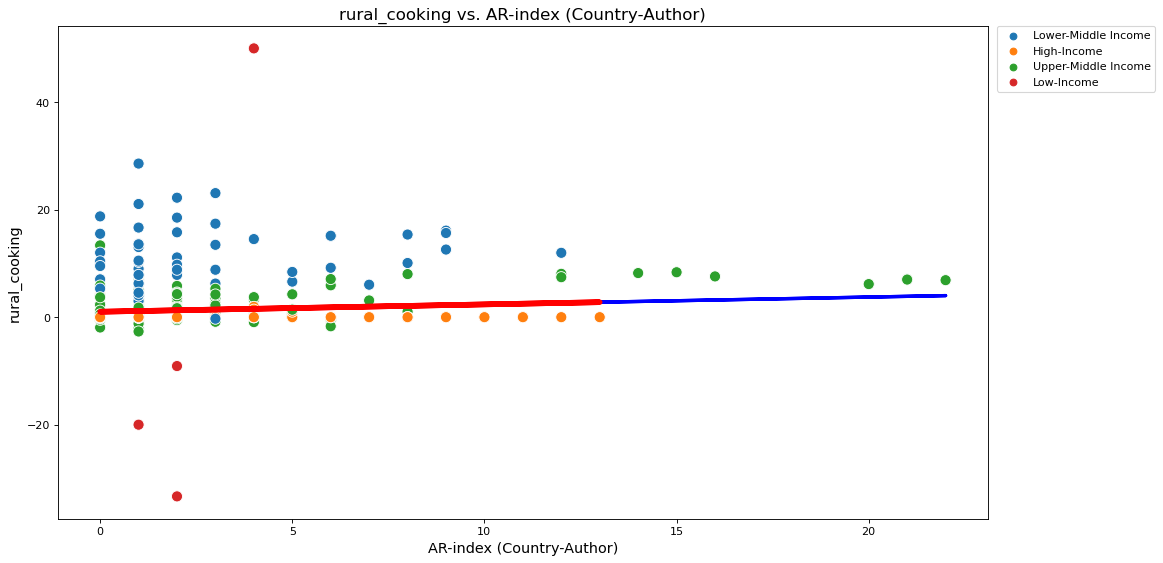

                            OLS Regression Results                            
Dep. Variable:          rural_cooking   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     4.972
Date:                Thu, 22 Dec 2022   Prob (F-statistic):             0.0262
Time:                        05:55:23   Log-Likelihood:                -1437.1
No. Observations:                 505   AIC:                             2878.
Df Residuals:                     503   BIC:                             2887.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.0129      0.259      3.904      

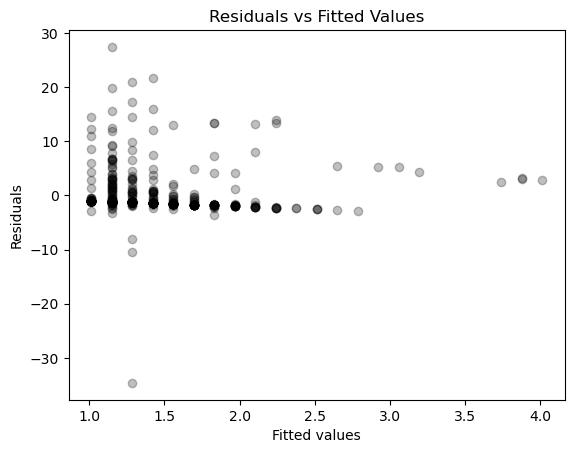

Residuals-- checking normality


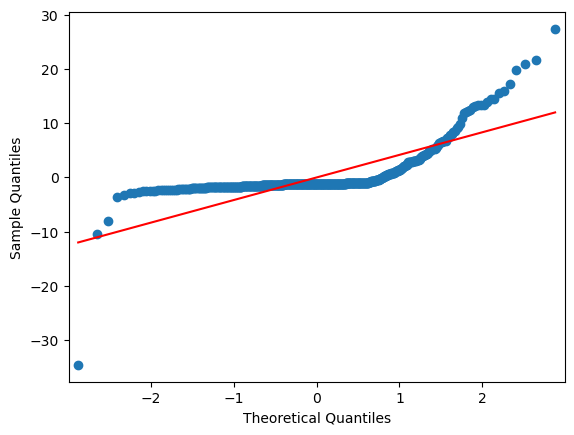

Residuals are not normal
Significant regression for:  [[], 'rural_cooking', [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]

Not significant regression for:  ['cooking', [], 'urban_cooking', 'electricity', 'rural_electricity', 'urban_electricity', 'nuclear_energy', 'combustible_renewable_waste', 'electric_consumption', 'eletric_loss', 'coal', 'hydroelectric', 'natural_gas', 'nuclear', 'oil', 'oil_gas_coal', 'electric_from_renewable', 'electric_from_renewable_kwh', 'energy_import', 'energy_intensity', 'energy_use_kg_capita', 'energy_use_kg_kgdp', 'fossil_fuel_consumption', 'gdp_over_energy_const_2017', 'gdp_over_energy', 'renewable_output', 'renewable_consumption']

Residuals are not normal when the following indicators are plotted against AR-index [[], 'rural_cooking', [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]


In [41]:
warnings.filterwarnings("ignore")
indicators = data.columns.tolist()[4:31]
significant = []
not_significant = []
resid_not_norm_y = []

for i in indicators:
    temp_df = data[['Year', 'Country Name', 'ar_index_ca', 'Economy Level',i]]
    temp_df['ar_index_ca'] = temp_df['ar_index_ca'].astype(int)
    
    ar_ind_bulk = temp_df['ar_index_ca']
    y_ind = temp_df[i]
    

    sig, not_sig, resids_not_normal = linear_regression_plot(ar_ind_bulk, y_ind, 'ar_index_ca', i, temp_df, 'AR-index (Country-Author)', i)
    significant.append(sig)
    not_significant.append(not_sig)
    resid_not_norm_y.append(resids_not_normal)

print('Significant regression for: ',significant)
print()
print('Not significant regression for: ',not_significant)
print()
print('Residuals are not normal when the following indicators are plotted against AR-index', resid_not_norm_y)
warnings.filterwarnings("default")

In [42]:
if len(significant) - len(resid_not_norm_y) == 0:
    print("Residuals are not normal for any of the significant regressions")

Residuals are not normal for any of the significant regressions


##### Storing results in a dataframe

In [43]:
significant_ind = [value for value in significant if value != []] 
val = len(significant_ind)

predictor = []
for i in range(val):
   predictor.append('AR-index') 


is_significant = []
for i in range(val):
   is_significant.append('Yes') 

# is_not_significant = []
# for i in range(val):
#    is_not_significant.append('NA') 

models_sig = pd.DataFrame(list(zip(predictor, significant_ind, is_significant)),
               columns =['predictor','indicator', 'is_significant'])


not_significant_ind = [value for value in not_significant if value != []]
val = len(not_significant_ind)

predictor = []
for i in range(val):
   predictor.append('AR-index') 


is_significant = []
for i in range(val):
   is_significant.append('No') 

# is_not_significant = []
# for i in range(val):
#    is_not_significant.append('yes') 

models_not_sig = pd.DataFrame(list(zip(predictor, not_significant_ind, is_significant)),
               columns =['predictor','indicator', 'is_significant'])

models = pd.concat([models_sig, models_not_sig],axis=0,ignore_index=True)
models

predictor                    indicator is_significant
0   AR-index                rural_cooking            Yes
1   AR-index                      cooking             No
2   AR-index                urban_cooking             No
3   AR-index                  electricity             No
4   AR-index            rural_electricity             No
5   AR-index            urban_electricity             No
6   AR-index               nuclear_energy             No
7   AR-index  combustible_renewable_waste             No
8   AR-index         electric_consumption             No
9   AR-index                 eletric_loss             No
10  AR-index                         coal             No
11  AR-index                hydroelectric             No
12  AR-index                  natural_gas             No
13  AR-index                      nuclear             No
14  AR-index                          oil             No
15  AR-index                 oil_gas_coal             No
16  AR-index      electric_from_renewable             No
17  AR-index  electric_from_renewable_kwh             No
18  AR-index                energy_import             No
19  AR-index             energy_intensity             No
20  AR-index         energy_use_kg_capita             No
21  AR-index           energy_use_kg_kgdp             No
22  AR-index      fossil_fuel_consumption             No
23  AR-index   gdp_over_energy_const_2017             No
24  AR-index              gdp_over_energy             No
25  AR-index             renewable_output             No
26  AR-index        renewable_consumption             No

### Quantile Regressions

#### - log_2_years






















energy_use_kg_kgdp vs log_2_Years


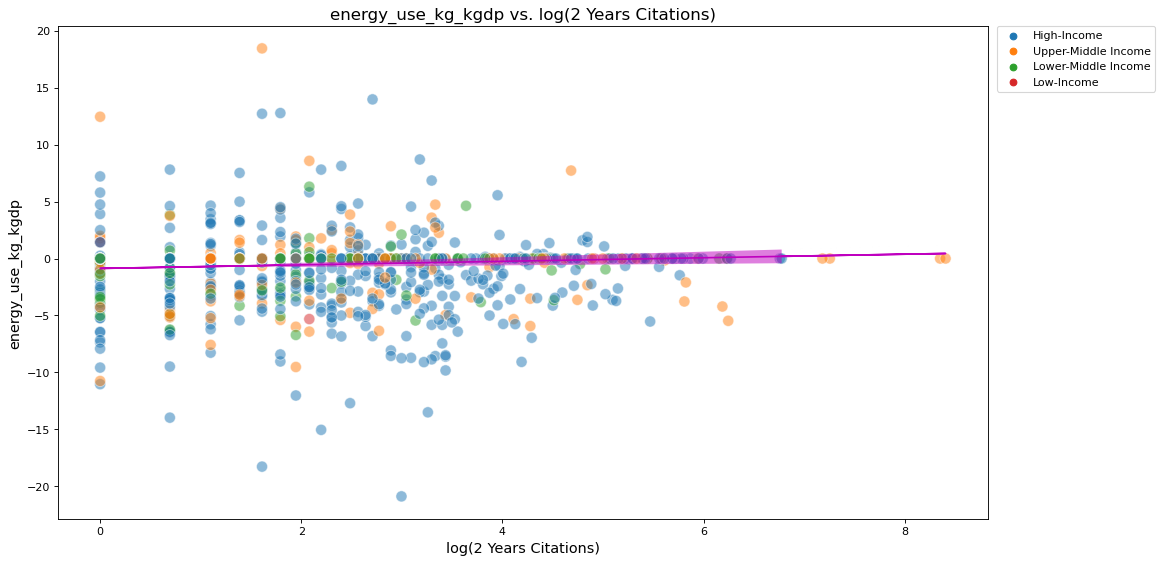

Average validation MSE over 5 folds:  13.711710920424025

                         QuantReg Regression Results                          
Dep. Variable:     energy_use_kg_kgdp   Pseudo R-squared:             0.008583
Model:                       QuantReg   Bandwidth:                       1.259
Method:                 Least Squares   Sparsity:                        4.361
Date:                Thu, 22 Dec 2022   No. Observations:                  747
Time:                        05:55:25   Df Residuals:                      745
                                        Df Model:                            1
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.8708      0.152     -5.729      0.000      -1.169      -0.572
log_2_Years     0.1562      0.050      3.128      0.002       0.058       0.254



gdp_over_energy_const_2017 vs log_2_Years


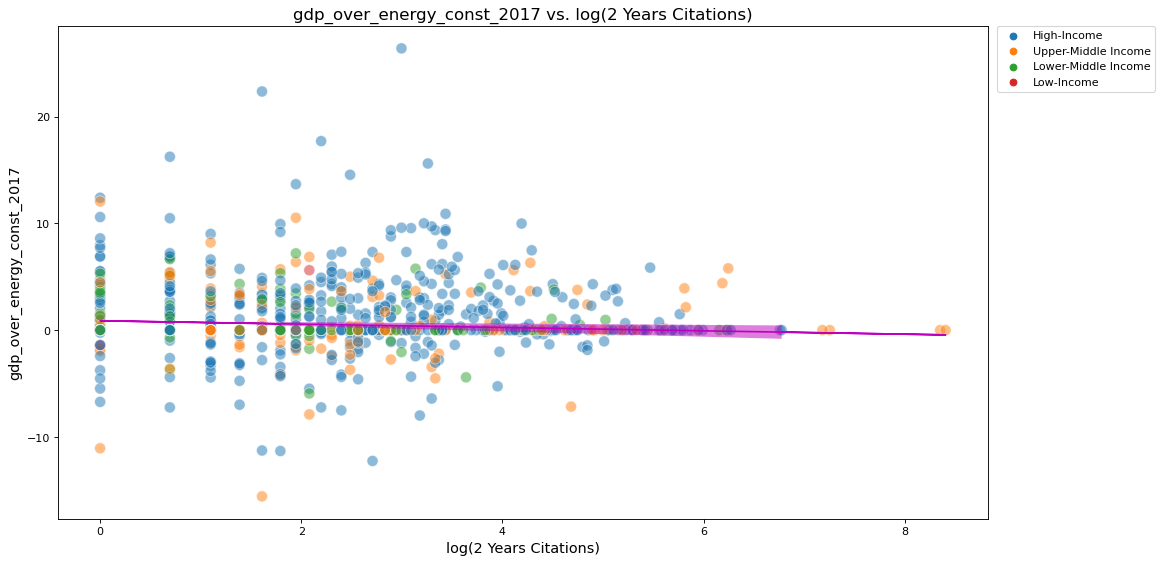

Average validation MSE over 5 folds:  14.801582971610278

                             QuantReg Regression Results                              
Dep. Variable:     gdp_over_energy_const_2017   Pseudo R-squared:             0.008371
Model:                               QuantReg   Bandwidth:                       1.298
Method:                         Least Squares   Sparsity:                        4.450
Date:                        Thu, 22 Dec 2022   No. Observations:                  747
Time:                                05:55:26   Df Residuals:                      745
                                                Df Model:                            1
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.8746      0.155      5.640      0.000       0.570       1.179
log_2_Years    -0.1569      0.051     -3.079      0.002      -0.257      -0.057


gdp_over_en

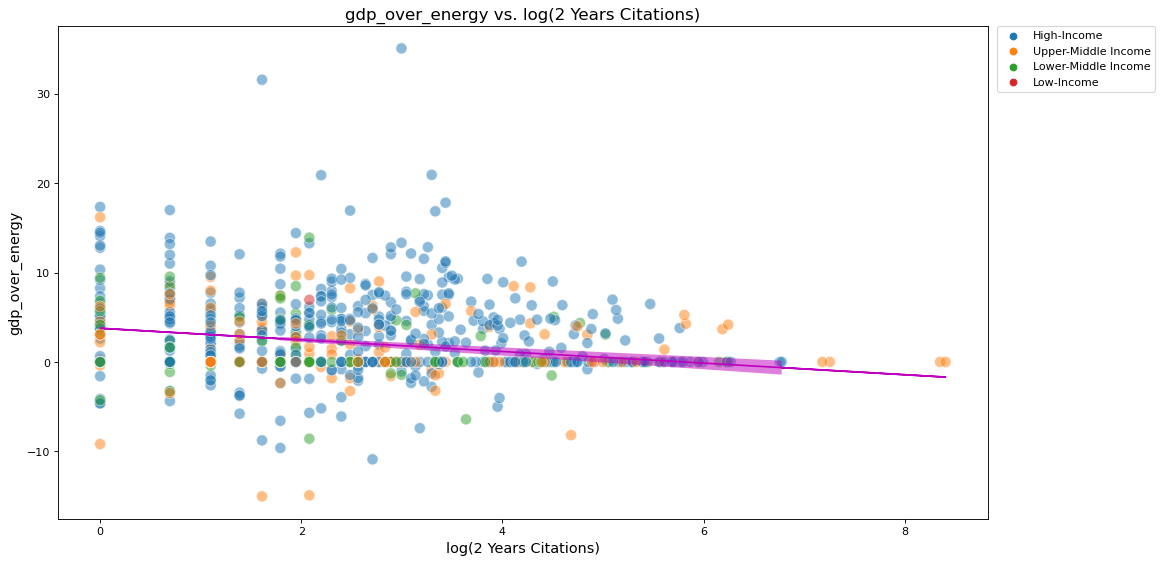

Average validation MSE over 5 folds:  23.110273490552757

                         QuantReg Regression Results                          
Dep. Variable:        gdp_over_energy   Pseudo R-squared:              0.03722
Model:                       QuantReg   Bandwidth:                       2.096
Method:                 Least Squares   Sparsity:                        9.616
Date:                Thu, 22 Dec 2022   No. Observations:                  747
Time:                        05:55:26   Df Residuals:                      745
                                        Df Model:                            1
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       3.7658      0.335     11.237      0.000       3.108       4.424
log_2_Years    -0.6494      0.110     -5.899      0.000      -0.866      -0.433




Significant regression for:  [[], [], [], [], [], [], [], [], [],

In [44]:
warnings.filterwarnings("ignore")
indicators = data.columns.tolist()[4:31] #needs to be changed according to df
significant = []
not_significant = []
resid_not_norm_y = []

for i in indicators:
    temp_df = data[['Year', 'Country Name', 'log_2_Years', 'Economy Level',i]]
    temp_df['log_2_Years'] = temp_df['log_2_Years'].astype(float)
    
    x_2_yrs_log = temp_df['log_2_Years']
    y_ind = temp_df[i]

    sig, not_sig = QR_cv_with_CI(x_2_yrs_log, y_ind, 'log_2_Years', i, temp_df, 'log(2 Years Citations)', i, 0.5)
    significant.append(sig)
    not_significant.append(not_sig)

print('Significant regression for: ',significant)
print()
print('Not significant regression for: ',not_significant)
print()
warnings.filterwarnings("default")

##### Storing results in a dataframe

In [45]:
significant_ind = [value for value in significant if value != []] 
val = len(significant_ind)

predictor = []
for i in range(val):
   predictor.append('log_2_years') 


is_significant = []
for i in range(val):
   is_significant.append('Yes') 

# is_not_significant = []
# for i in range(val):
#    is_not_significant.append('NA') 

models_sig = pd.DataFrame(list(zip(predictor, significant_ind, is_significant)),
               columns =['predictor','indicator', 'is_significant'])


not_significant_ind = [value for value in not_significant if value != []]
val = len(not_significant_ind)

predictor = []
for i in range(val):
   predictor.append('log_2_years') 


is_significant = []
for i in range(val):
   is_significant.append('No') 

# is_not_significant = []
# for i in range(val):
#    is_not_significant.append('yes') 

models_not_sig = pd.DataFrame(list(zip(predictor, not_significant_ind, is_significant)),
               columns =['predictor','indicator', 'is_significant'])

models = pd.concat([models_sig, models_not_sig],axis=0,ignore_index=True)
models

predictor                    indicator is_significant
0   log_2_years           energy_use_kg_kgdp            Yes
1   log_2_years   gdp_over_energy_const_2017            Yes
2   log_2_years              gdp_over_energy            Yes
3   log_2_years                      cooking             No
4   log_2_years                rural_cooking             No
5   log_2_years                urban_cooking             No
6   log_2_years                  electricity             No
7   log_2_years            rural_electricity             No
8   log_2_years            urban_electricity             No
9   log_2_years               nuclear_energy             No
10  log_2_years  combustible_renewable_waste             No
11  log_2_years         electric_consumption             No
12  log_2_years                 eletric_loss             No
13  log_2_years                         coal             No
14  log_2_years                hydroelectric             No
15  log_2_years                  natural_gas             No
16  log_2_years                      nuclear             No
17  log_2_years                          oil             No
18  log_2_years                 oil_gas_coal             No
19  log_2_years      electric_from_renewable             No
20  log_2_years  electric_from_renewable_kwh             No
21  log_2_years                energy_import             No
22  log_2_years             energy_intensity             No
23  log_2_years         energy_use_kg_capita             No
24  log_2_years      fossil_fuel_consumption             No
25  log_2_years             renewable_output             No
26  log_2_years        renewable_consumption             No

#### - AR-index

In [46]:
warnings.filterwarnings("ignore")
indicators = data.columns.tolist()[5:31]
significant = []
not_significant = []
resid_not_norm_y = []

for i in indicators:
    temp_df = data[['Year', 'Country Name', 'ar_index_ca', 'Economy Level',i]]
    temp_df['ar_index_ca'] = temp_df['ar_index_ca'].astype(int)
    
    ar_ind_bulk = temp_df['ar_index_ca']
    y_ind = temp_df[i]

    sig, not_sig = QR_cv_with_CI(ar_ind_bulk, y_ind, 'ar_index_ca', i, temp_df, 'AR-index (Country-Author)', i, 0.5)
    significant.append(sig)
    not_significant.append(not_sig)

print('Significant regression for: ',significant)
print()
print('Not significant regression for: ',not_significant)
print()
warnings.filterwarnings("default")



























Significant regression for:  [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]

Not significant regression for:  ['rural_cooking', 'urban_cooking', 'electricity', 'rural_electricity', 'urban_electricity', 'nuclear_energy', 'combustible_renewable_waste', 'electric_consumption', 'eletric_loss', 'coal', 'hydroelectric', 'natural_gas', 'nuclear', 'oil', 'oil_gas_coal', 'electric_from_renewable', 'electric_from_renewable_kwh', 'energy_import', 'energy_intensity', 'energy_use_kg_capita', 'energy_use_kg_kgdp', 'fossil_fuel_consumption', 'gdp_over_energy_const_2017', 'gdp_over_energy', 'renewable_output', 'renewable_consumption']



##### Storing results in a dataframe

In [47]:
significant_ind = [value for value in significant if value != []] 
val = len(significant_ind)

predictor = []
for i in range(val):
   predictor.append('AR-index') 


is_significant = []
for i in range(val):
   is_significant.append('Yes') 

# is_not_significant = []
# for i in range(val):
#    is_not_significant.append('NA') 

models_sig = pd.DataFrame(list(zip(predictor, significant_ind, is_significant)),
               columns =['predictor','indicator', 'is_significant'])


not_significant_ind = [value for value in not_significant if value != []]
val = len(not_significant_ind)

predictor = []
for i in range(val):
   predictor.append('AR-index') 


is_significant = []
for i in range(val):
   is_significant.append('No') 

# is_not_significant = []
# for i in range(val):
#    is_not_significant.append('yes') 

models_not_sig = pd.DataFrame(list(zip(predictor, not_significant_ind, is_significant)),
               columns =['predictor','indicator', 'is_significant'])

models = pd.concat([models_sig, models_not_sig],axis=0,ignore_index=True)
models

predictor                    indicator is_significant
0   AR-index                rural_cooking             No
1   AR-index                urban_cooking             No
2   AR-index                  electricity             No
3   AR-index            rural_electricity             No
4   AR-index            urban_electricity             No
5   AR-index               nuclear_energy             No
6   AR-index  combustible_renewable_waste             No
7   AR-index         electric_consumption             No
8   AR-index                 eletric_loss             No
9   AR-index                         coal             No
10  AR-index                hydroelectric             No
11  AR-index                  natural_gas             No
12  AR-index                      nuclear             No
13  AR-index                          oil             No
14  AR-index                 oil_gas_coal             No
15  AR-index      electric_from_renewable             No
16  AR-index  electric_from_renewable_kwh             No
17  AR-index                energy_import             No
18  AR-index             energy_intensity             No
19  AR-index         energy_use_kg_capita             No
20  AR-index           energy_use_kg_kgdp             No
21  AR-index      fossil_fuel_consumption             No
22  AR-index   gdp_over_energy_const_2017             No
23  AR-index              gdp_over_energy             No
24  AR-index             renewable_output             No
25  AR-index        renewable_consumption             No

# Regressions with log diff of indicators

- Only significant regressions and assumptions are printed 

In [48]:
# data = pd.read_csv('data/indicators_citations_bulk_df.csv')
# data = pd.read_csv('data/dist_calc_citations_bulk_df.csv') 
# data = pd.read_csv('data/pc_change_citations_bulk_df.csv')
data = pd.read_csv('data/log_diff_citations_ca_df.csv')
cols = data.columns[0]
data = data.drop(columns = cols)
income = pd.read_csv('data/wdi_incomelevels.csv')

#all zeros for citations were dropped in building the data frame
data['log_2_Years'] = np.log(data['2 years window'])

#merge with income
income['Country'] = income['Country'].str.lower()
income = income.rename(columns={'Country': 'Country Name'})
data = pd.merge(data, income, on=['Country Name'], how='left') 

#change column names to prevent patsy error issue with quantile regression
data = data.rename(columns={'electricy': 'electricity'})
data = data.rename(columns={'urban_electricy': 'urban_electricity'})
data = data.rename(columns={'rural_electricy': 'rural_electricity'})
data = data.rename(columns={'electric_from_renuable': 'electric_from_renewable'})
data = data.rename(columns={'energy_use(kg/capita)': 'energy_use_kg_capita'})
data = data.rename(columns={'energy_use(kg/kGDP)': 'energy_use_kg_kgdp'})
data = data.rename(columns={'GDP/Energy(constrant_2017)': 'gdp_over_energy_const_2017'})
data = data.rename(columns={'fossil_fual_comsumption': 'fossil_fuel_consumption'}) 
data = data.rename(columns={'renewable_comsumption': 'renewable_consumption'})
data = data.rename(columns={'GDP/Energy': 'gdp_over_energy'})

data = data.rename(columns={'combustiable_renewable_waste': 'combustible_renewable_waste'})
data = data.rename(columns={'hydroeletric': 'hydroelectric'})
data = data.rename(columns={'natrual_gas': 'natural_gas'})
data = data.rename(columns={'electric_from_renuable_kwh': 'electric_from_renewable_kwh'})

data = data.rename(columns={'ar index ca': 'ar_index_ca'})

data.head(4)

Year    Country Name  2 years window  ar_index_ca  cooking  rural_cooking  \
0  1991           india             1.0     0.707107      NaN            NaN   
1  1991  united kingdom             5.0     0.516398      NaN            NaN   
2  1992          brazil             2.0     0.454859      NaN            NaN   
3  1994           china             1.0     0.192450      NaN            NaN   

   urban_cooking  electricity  rural_electricity  urban_electricity  \
0            NaN          NaN                NaN                NaN   
1            NaN          NaN                NaN                NaN   
2            NaN          NaN                NaN                NaN   
3            NaN          NaN                NaN                NaN   

   nuclear_energy  combustible_renewable_waste  electric_consumption  \
0             NaN                          NaN                   NaN   
1             NaN                          NaN                   NaN   
2             NaN                          NaN                   NaN   
3             NaN                          NaN                   NaN   

   eletric_loss  coal  hydroelectric  natural_gas  nuclear  oil  oil_gas_coal  \
0           NaN   NaN            NaN          NaN      NaN  NaN           NaN   
1           NaN   NaN            NaN          NaN      NaN  NaN           NaN   
2           NaN   NaN            NaN          NaN      NaN  NaN           NaN   
3           NaN   NaN            NaN          NaN      NaN  NaN           NaN   

   electric_from_renewable  electric_from_renewable_kwh  energy_import  \
0                      NaN                          NaN            NaN   
1                      NaN                          NaN            NaN   
2                      NaN                          NaN            NaN   
3                      NaN                          NaN            NaN   

   energy_intensity  energy_use_kg_capita  energy_use_kg_kgdp  \
0               NaN                   NaN                 NaN   
1               NaN                   NaN                 NaN   
2               NaN                   NaN                 NaN   
3               NaN                   NaN                 NaN   

   fossil_fuel_consumption  gdp_over_energy_const_2017  gdp_over_energy  \
0                      NaN                         NaN              NaN   
1                      NaN                         NaN              NaN   
2                      NaN                         NaN              NaN   
3                      NaN                         NaN              NaN   

   renewable_output  renewable_consumption  log_2_Years        Economy Level  
0               NaN                    NaN     0.000000  Lower-Middle Income  
1               NaN                    NaN     1.609438          High-Income  
2               NaN                    NaN     0.693147  Upper-Middle Income  
3               NaN                    NaN     0.000000  Upper-Middle Income

### Simple Linear Regressions

#### - log_2_years

In [49]:
warnings.filterwarnings("ignore")
indicators = data.columns.tolist()[4:31] #needs to be changed according to df
significant = []
not_significant = []
resid_not_norm_y = []

for i in indicators:
    temp_df = data[['Year', 'Country Name', '2 years window', 'log_2_Years', 'Economy Level',i]]
    temp_df['log_2_Years'] = temp_df['log_2_Years'].astype(float)
    
    x_2_yrs_log = temp_df['log_2_Years']
    y_ind = temp_df[i]
    

    sig, not_sig, resids_not_normal = linear_regression_plot(x_2_yrs_log, y_ind, 'log_2_Years', i, temp_df, 'log(2 Years Citations)', i)
    significant.append(sig)
    not_significant.append(not_sig)
    resid_not_norm_y.append(resids_not_normal)

print('Significant regression for: ',significant)
print()
print('Not significant regression for: ',not_significant)
print()
print('Residuals are not normal when the following indicators are plotted against log(2 years)', resid_not_norm_y)
warnings.filterwarnings("default")

Significant regression for:  [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]

Not significant regression for:  ['cooking', 'rural_cooking', 'urban_cooking', 'electricity', 'rural_electricity', 'urban_electricity', 'nuclear_energy', 'combustible_renewable_waste', 'electric_consumption', 'eletric_loss', 'coal', 'hydroelectric', 'natural_gas', 'nuclear', 'oil', 'oil_gas_coal', 'electric_from_renewable', 'electric_from_renewable_kwh', 'energy_import', 'energy_intensity', 'energy_use_kg_capita', 'energy_use_kg_kgdp', 'fossil_fuel_consumption', 'gdp_over_energy_const_2017', 'gdp_over_energy', 'renewable_output', 'renewable_consumption']

Residuals are not normal when the following indicators are plotted against log(2 years) [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]


In [50]:
if len(significant) - len(resid_not_norm_y) == 0:
    print("Residuals are not normal for any of the significant regressions")

Residuals are not normal for any of the significant regressions


##### Storing results in dataframe

In [51]:
significant_ind = [value for value in significant if value != []] 
val = len(significant_ind)

predictor = []
for i in range(val):
   predictor.append('log_2_years') 


is_significant = []
for i in range(val):
   is_significant.append('Yes') 

# is_not_significant = []
# for i in range(val):
#    is_not_significant.append('NA') 

models_sig = pd.DataFrame(list(zip(predictor, significant_ind, is_significant)),
               columns =['predictor','indicator', 'is_significant'])


not_significant_ind = [value for value in not_significant if value != []]
val = len(not_significant_ind)

predictor = []
for i in range(val):
   predictor.append('log_2_years') 


is_significant = []
for i in range(val):
   is_significant.append('No') 

# is_not_significant = []
# for i in range(val):
#    is_not_significant.append('yes') 

models_not_sig = pd.DataFrame(list(zip(predictor, not_significant_ind, is_significant)),
               columns =['predictor','indicator', 'is_significant'])

models = pd.concat([models_sig, models_not_sig],axis=0,ignore_index=True)
models

predictor                    indicator is_significant
0   log_2_years                      cooking             No
1   log_2_years                rural_cooking             No
2   log_2_years                urban_cooking             No
3   log_2_years                  electricity             No
4   log_2_years            rural_electricity             No
5   log_2_years            urban_electricity             No
6   log_2_years               nuclear_energy             No
7   log_2_years  combustible_renewable_waste             No
8   log_2_years         electric_consumption             No
9   log_2_years                 eletric_loss             No
10  log_2_years                         coal             No
11  log_2_years                hydroelectric             No
12  log_2_years                  natural_gas             No
13  log_2_years                      nuclear             No
14  log_2_years                          oil             No
15  log_2_years                 oil_gas_coal             No
16  log_2_years      electric_from_renewable             No
17  log_2_years  electric_from_renewable_kwh             No
18  log_2_years                energy_import             No
19  log_2_years             energy_intensity             No
20  log_2_years         energy_use_kg_capita             No
21  log_2_years           energy_use_kg_kgdp             No
22  log_2_years      fossil_fuel_consumption             No
23  log_2_years   gdp_over_energy_const_2017             No
24  log_2_years              gdp_over_energy             No
25  log_2_years             renewable_output             No
26  log_2_years        renewable_consumption             No

##### Plotting non significant indicators against log_2_years

In [52]:
# #colored by economy level
# for i in models_not_sig['indicator']:
    
#     print(i+' vs log_2_years')
#     plt.figure(figsize=(15, 8), dpi=80)
#     p1 = sns.scatterplot(x = 'log_2_Years', y = i, data = data, hue='Economy Level', s=100)
#     p1.legend(bbox_to_anchor=(1.01,1.0), loc='upper left', borderaxespad=0)#,borderaxespad = 0., ncol = 1)
#     plt.xlabel('log_2_years', fontsize=13)
#     plt.ylabel(i, fontsize=13)
#     plt.title(i +' vs log_2_years', fontsize=15)

#     plt.show()

#### - AR-index

rural_cooking vs ar_index_ca


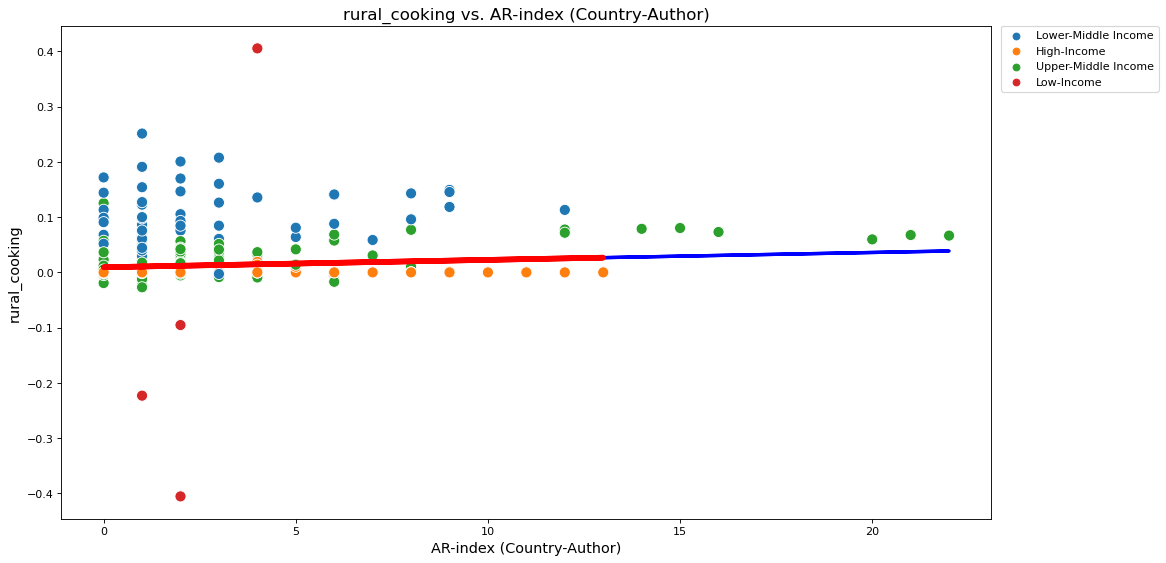

                            OLS Regression Results                            
Dep. Variable:          rural_cooking   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     5.048
Date:                Thu, 22 Dec 2022   Prob (F-statistic):             0.0251
Time:                        05:55:29   Log-Likelihood:                 901.98
No. Observations:                 505   AIC:                            -1800.
Df Residuals:                     503   BIC:                            -1792.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0093      0.003      3.671      

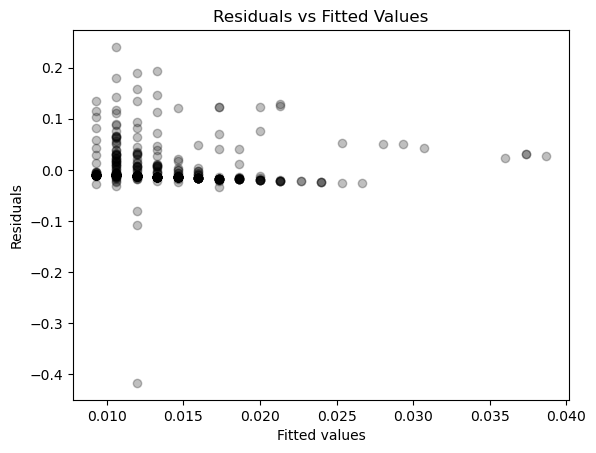

Residuals-- checking normality


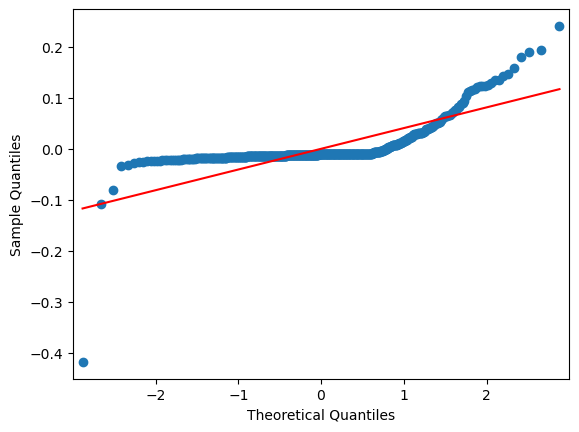

Residuals are not normal
Significant regression for:  [[], 'rural_cooking', [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]

Not significant regression for:  ['cooking', [], 'urban_cooking', 'electricity', 'rural_electricity', 'urban_electricity', 'nuclear_energy', 'combustible_renewable_waste', 'electric_consumption', 'eletric_loss', 'coal', 'hydroelectric', 'natural_gas', 'nuclear', 'oil', 'oil_gas_coal', 'electric_from_renewable', 'electric_from_renewable_kwh', 'energy_import', 'energy_intensity', 'energy_use_kg_capita', 'energy_use_kg_kgdp', 'fossil_fuel_consumption', 'gdp_over_energy_const_2017', 'gdp_over_energy', 'renewable_output', 'renewable_consumption']

Residuals are not normal when the following indicators are plotted against AR-index [[], 'rural_cooking', [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]


In [53]:
warnings.filterwarnings("ignore")
indicators = data.columns.tolist()[4:31]
significant = []
not_significant = []
resid_not_norm_y = []

for i in indicators:
    temp_df = data[['Year', 'Country Name', 'ar_index_ca', 'Economy Level',i]]
    temp_df['ar_index_ca'] = temp_df['ar_index_ca'].astype(int)
    
    ar_ind_bulk = temp_df['ar_index_ca']
    y_ind = temp_df[i]
    

    sig, not_sig, resids_not_normal = linear_regression_plot(ar_ind_bulk, y_ind, 'ar_index_ca', i, temp_df, 'AR-index (Country-Author)', i)
    significant.append(sig)
    not_significant.append(not_sig)
    resid_not_norm_y.append(resids_not_normal)

print('Significant regression for: ',significant)
print()
print('Not significant regression for: ',not_significant)
print()
print('Residuals are not normal when the following indicators are plotted against AR-index', resid_not_norm_y)
warnings.filterwarnings("default")

In [54]:
if len(significant) - len(resid_not_norm_y) == 0:
    print("Residuals are not normal for any of the significant regressions")

Residuals are not normal for any of the significant regressions


##### Storing results in a dataframe

In [55]:
significant_ind = [value for value in significant if value != []] 
val = len(significant_ind)

predictor = []
for i in range(val):
   predictor.append('AR-index') 


is_significant = []
for i in range(val):
   is_significant.append('Yes') 

# is_not_significant = []
# for i in range(val):
#    is_not_significant.append('NA') 

models_sig = pd.DataFrame(list(zip(predictor, significant_ind, is_significant)),
               columns =['predictor','indicator', 'is_significant'])


not_significant_ind = [value for value in not_significant if value != []]
val = len(not_significant_ind)

predictor = []
for i in range(val):
   predictor.append('AR-index') 


is_significant = []
for i in range(val):
   is_significant.append('No') 

# is_not_significant = []
# for i in range(val):
#    is_not_significant.append('yes') 

models_not_sig = pd.DataFrame(list(zip(predictor, not_significant_ind, is_significant)),
               columns =['predictor','indicator', 'is_significant'])

models = pd.concat([models_sig, models_not_sig],axis=0,ignore_index=True)
models

predictor                    indicator is_significant
0   AR-index                rural_cooking            Yes
1   AR-index                      cooking             No
2   AR-index                urban_cooking             No
3   AR-index                  electricity             No
4   AR-index            rural_electricity             No
5   AR-index            urban_electricity             No
6   AR-index               nuclear_energy             No
7   AR-index  combustible_renewable_waste             No
8   AR-index         electric_consumption             No
9   AR-index                 eletric_loss             No
10  AR-index                         coal             No
11  AR-index                hydroelectric             No
12  AR-index                  natural_gas             No
13  AR-index                      nuclear             No
14  AR-index                          oil             No
15  AR-index                 oil_gas_coal             No
16  AR-index      electric_from_renewable             No
17  AR-index  electric_from_renewable_kwh             No
18  AR-index                energy_import             No
19  AR-index             energy_intensity             No
20  AR-index         energy_use_kg_capita             No
21  AR-index           energy_use_kg_kgdp             No
22  AR-index      fossil_fuel_consumption             No
23  AR-index   gdp_over_energy_const_2017             No
24  AR-index              gdp_over_energy             No
25  AR-index             renewable_output             No
26  AR-index        renewable_consumption             No

### Quantile Regressions

#### - log_2_years









electric_consumption vs log_2_Years


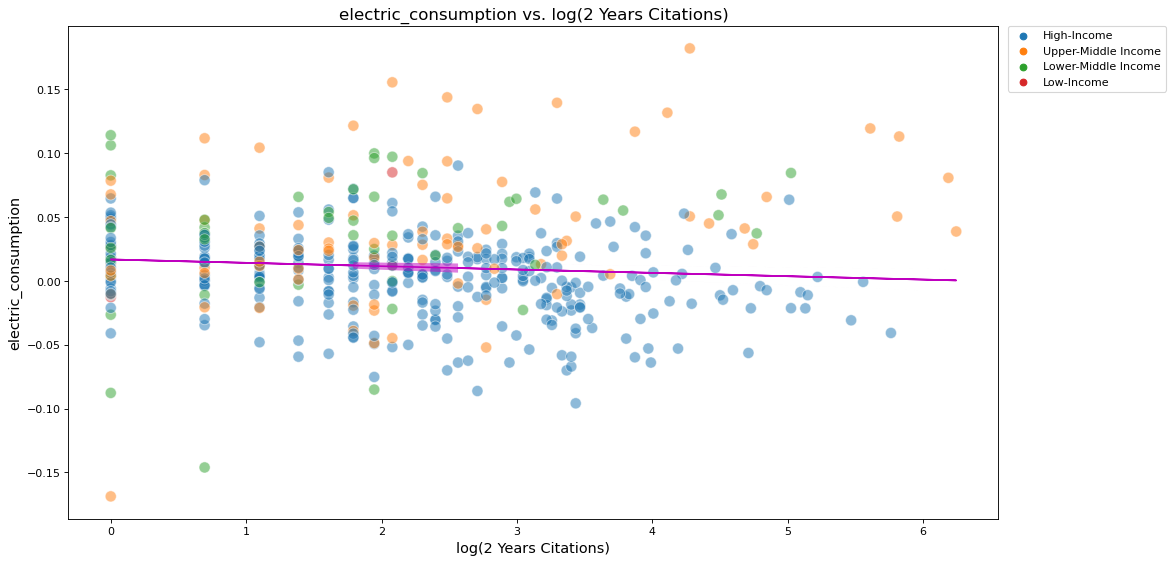

Average validation MSE over 5 folds:  0.001695256337511119

                          QuantReg Regression Results                           
Dep. Variable:     electric_consumption   Pseudo R-squared:             0.007032
Model:                         QuantReg   Bandwidth:                     0.01897
Method:                   Least Squares   Sparsity:                      0.07662
Date:                  Thu, 22 Dec 2022   No. Observations:                  504
Time:                          05:55:30   Df Residuals:                      502
                                          Df Model:                            1
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0168      0.003      5.222      0.000       0.010       0.023
log_2_Years    -0.0026      0.001     -2.126      0.034      -0.005      -0.000















fossil_fuel_consumption vs log_2_Years

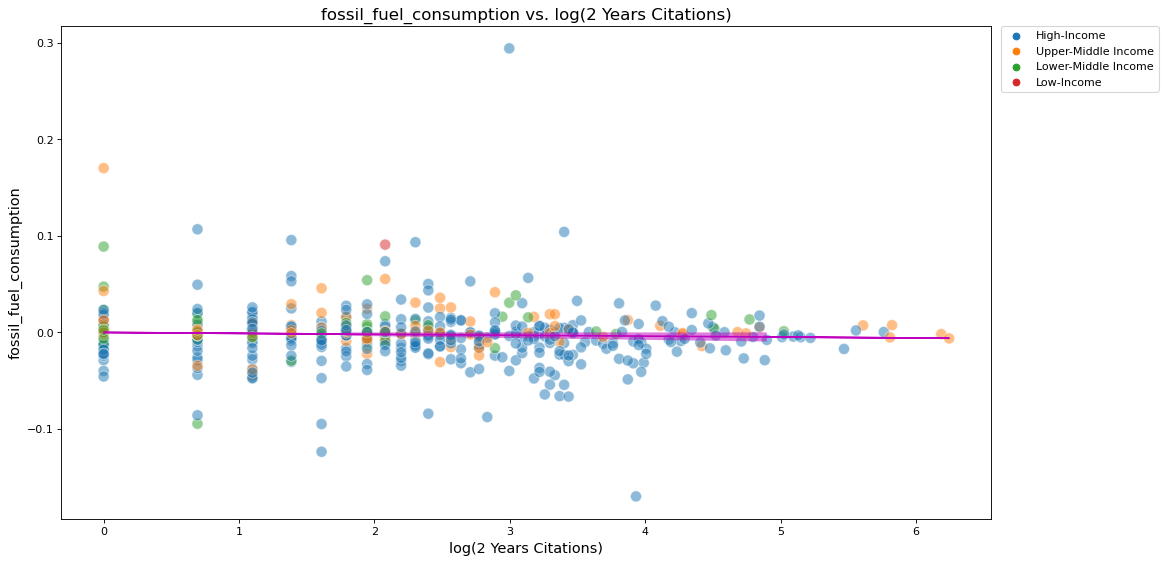

Average validation MSE over 5 folds:  0.0008716417315420046

                            QuantReg Regression Results                            
Dep. Variable:     fossil_fuel_consumption   Pseudo R-squared:             0.003654
Model:                            QuantReg   Bandwidth:                    0.008364
Method:                      Least Squares   Sparsity:                      0.03075
Date:                     Thu, 22 Dec 2022   No. Observations:                  524
Time:                             05:55:30   Df Residuals:                      522
                                             Df Model:                            1
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.0003      0.001     -0.218      0.828      -0.003       0.002
log_2_Years    -0.0010      0.000     -1.987      0.047      -0.002   -1.07e-05






Significant regression fo

In [56]:
warnings.filterwarnings("ignore")
indicators = data.columns.tolist()[4:31] #needs to be changed according to df
significant = []
not_significant = []
resid_not_norm_y = []

for i in indicators:
    temp_df = data[['Year', 'Country Name', 'log_2_Years', 'Economy Level',i]]
    temp_df['log_2_Years'] = temp_df['log_2_Years'].astype(float)
    
    x_2_yrs_log = temp_df['log_2_Years']
    y_ind = temp_df[i]

    sig, not_sig = QR_cv_with_CI(x_2_yrs_log, y_ind, 'log_2_Years', i, temp_df, 'log(2 Years Citations)', i, 0.5)
    significant.append(sig)
    not_significant.append(not_sig)

print('Significant regression for: ',significant)
print()
print('Not significant regression for: ',not_significant)
print()
warnings.filterwarnings("default")

##### Storing results in a dataframe

In [57]:
significant_ind = [value for value in significant if value != []] 
val = len(significant_ind)

predictor = []
for i in range(val):
   predictor.append('log_2_years') 


is_significant = []
for i in range(val):
   is_significant.append('Yes') 

# is_not_significant = []
# for i in range(val):
#    is_not_significant.append('NA') 

models_sig = pd.DataFrame(list(zip(predictor, significant_ind, is_significant)),
               columns =['predictor','indicator', 'is_significant'])


not_significant_ind = [value for value in not_significant if value != []]
val = len(not_significant_ind)

predictor = []
for i in range(val):
   predictor.append('log_2_years') 


is_significant = []
for i in range(val):
   is_significant.append('No') 

# is_not_significant = []
# for i in range(val):
#    is_not_significant.append('yes') 

models_not_sig = pd.DataFrame(list(zip(predictor, not_significant_ind, is_significant)),
               columns =['predictor','indicator', 'is_significant'])

models = pd.concat([models_sig, models_not_sig],axis=0,ignore_index=True)
models

predictor                    indicator is_significant
0   log_2_years         electric_consumption            Yes
1   log_2_years      fossil_fuel_consumption            Yes
2   log_2_years                      cooking             No
3   log_2_years                rural_cooking             No
4   log_2_years                urban_cooking             No
5   log_2_years                  electricity             No
6   log_2_years            rural_electricity             No
7   log_2_years            urban_electricity             No
8   log_2_years               nuclear_energy             No
9   log_2_years  combustible_renewable_waste             No
10  log_2_years                 eletric_loss             No
11  log_2_years                         coal             No
12  log_2_years                hydroelectric             No
13  log_2_years                  natural_gas             No
14  log_2_years                      nuclear             No
15  log_2_years                          oil             No
16  log_2_years                 oil_gas_coal             No
17  log_2_years      electric_from_renewable             No
18  log_2_years  electric_from_renewable_kwh             No
19  log_2_years                energy_import             No
20  log_2_years             energy_intensity             No
21  log_2_years         energy_use_kg_capita             No
22  log_2_years           energy_use_kg_kgdp             No
23  log_2_years   gdp_over_energy_const_2017             No
24  log_2_years              gdp_over_energy             No
25  log_2_years             renewable_output             No
26  log_2_years        renewable_consumption             No

#### - AR-index


















energy_import vs ar_index_ca


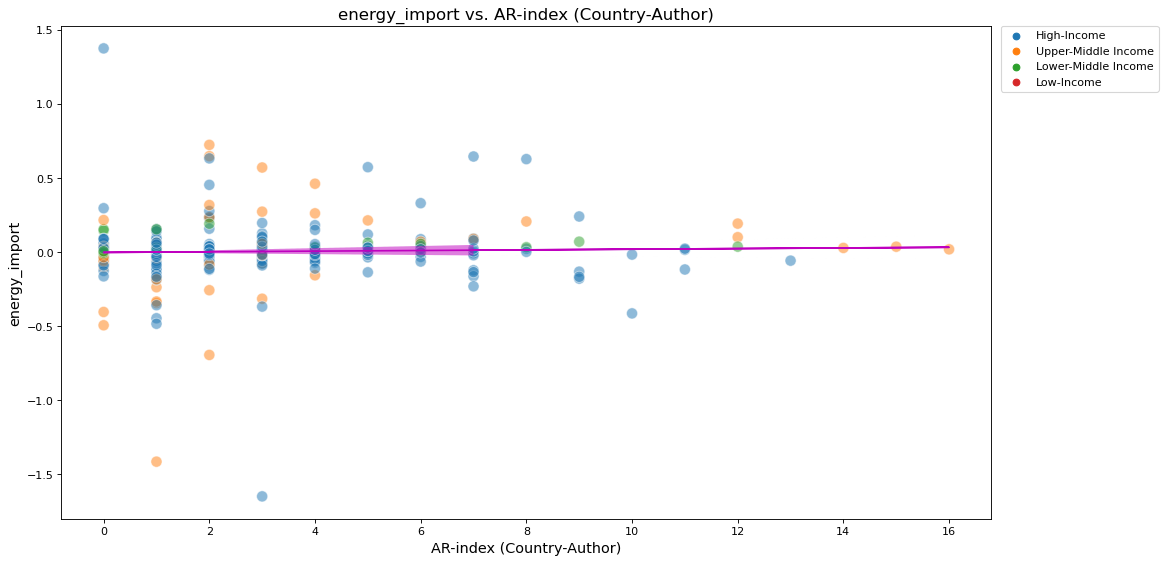

Average validation MSE over 5 folds:  0.03680322934050789

                         QuantReg Regression Results                          
Dep. Variable:          energy_import   Pseudo R-squared:             0.003040
Model:                       QuantReg   Bandwidth:                     0.02822
Method:                 Least Squares   Sparsity:                      0.09992
Date:                Thu, 22 Dec 2022   No. Observations:                  397
Time:                        05:55:32   Df Residuals:                      395
                                        Df Model:                            1
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.0031      0.004     -0.873      0.383      -0.010       0.004
ar_index_ca     0.0022      0.001      2.333      0.020       0.000       0.004










Significant regression for:  [[], [], [], [], [], [], [], 

In [58]:
warnings.filterwarnings("ignore")
indicators = data.columns.tolist()[5:31]
significant = []
not_significant = []
resid_not_norm_y = []

for i in indicators:
    temp_df = data[['Year', 'Country Name', 'ar_index_ca', 'Economy Level',i]]
    temp_df['ar_index_ca'] = temp_df['ar_index_ca'].astype(int)
    
    ar_ind_bulk = temp_df['ar_index_ca']
    y_ind = temp_df[i]

    sig, not_sig = QR_cv_with_CI(ar_ind_bulk, y_ind, 'ar_index_ca', i, temp_df, 'AR-index (Country-Author)', i, 0.5)
    significant.append(sig)
    not_significant.append(not_sig)

print('Significant regression for: ',significant)
print()
print('Not significant regression for: ',not_significant)
print()
warnings.filterwarnings("default")

In [59]:
if len(significant) - len(resid_not_norm_y) == 0:
    print("Residuals are not normal for any of the significant regressions")

##### Storing results in a dataframe

In [60]:
significant_ind = [value for value in significant if value != []] 
val = len(significant_ind)

predictor = []
for i in range(val):
   predictor.append('AR-index') 


is_significant = []
for i in range(val):
   is_significant.append('Yes') 

# is_not_significant = []
# for i in range(val):
#    is_not_significant.append('NA') 

models_sig = pd.DataFrame(list(zip(predictor, significant_ind, is_significant)),
               columns =['predictor','indicator', 'is_significant'])


not_significant_ind = [value for value in not_significant if value != []]
val = len(not_significant_ind)

predictor = []
for i in range(val):
   predictor.append('AR-index') 


is_significant = []
for i in range(val):
   is_significant.append('No') 

# is_not_significant = []
# for i in range(val):
#    is_not_significant.append('yes') 

models_not_sig = pd.DataFrame(list(zip(predictor, not_significant_ind, is_significant)),
               columns =['predictor','indicator', 'is_significant'])

models = pd.concat([models_sig, models_not_sig],axis=0,ignore_index=True)
models

predictor                    indicator is_significant
0   AR-index                energy_import            Yes
1   AR-index                rural_cooking             No
2   AR-index                urban_cooking             No
3   AR-index                  electricity             No
4   AR-index            rural_electricity             No
5   AR-index            urban_electricity             No
6   AR-index               nuclear_energy             No
7   AR-index  combustible_renewable_waste             No
8   AR-index         electric_consumption             No
9   AR-index                 eletric_loss             No
10  AR-index                         coal             No
11  AR-index                hydroelectric             No
12  AR-index                  natural_gas             No
13  AR-index                      nuclear             No
14  AR-index                          oil             No
15  AR-index                 oil_gas_coal             No
16  AR-index      electric_from_renewable             No
17  AR-index  electric_from_renewable_kwh             No
18  AR-index             energy_intensity             No
19  AR-index         energy_use_kg_capita             No
20  AR-index           energy_use_kg_kgdp             No
21  AR-index      fossil_fuel_consumption             No
22  AR-index   gdp_over_energy_const_2017             No
23  AR-index              gdp_over_energy             No
24  AR-index             renewable_output             No
25  AR-index        renewable_consumption             No

# Regressions with distance measure of indicators

- Only significant regressions and assumptions are printed 

## All countries

In [64]:
ylabel_names = ['Distance Measure for Access to clean fuels and technologies for cooking (% of population)',
               'Distance Measure for Access to clean fuels and technologies for cooking, rural (% of rural population)',
               'Distance Measure for Access to clean fuels and technologies for cooking, urban (% of urban population)',
               'Distance Measure for Access to electricity (% of population)',
               'Distance Measure for Access to electricity, rural (% of rural population)',
               'Distance Measure for Access to electricity, urban (% of urban population)',
               'Distance Measure for Electricity production from coal sources (% of total)',
               'Distance Measure for Electricity production from oil, gas and coal sources (% of total)',
               'Distance Measure for Energy use (Kg/Capita)',
               'Distance Measure for Fossil fuel energy consumption (% of total)',
               'Distance Measure for Renewable electricity output (% of total electricity output)',
               'Distance Measure for Renewable energy consumption (% of total final energy consumption)']

In [65]:
# data = pd.read_csv('data/indicators_citations_bulk_df.csv')
data = pd.read_csv('data/dist_calc_citations_ca_df.csv')
cols = data.columns[0]
data = data.drop(columns = cols)
# data = pd.read_csv('data/pc_change_citations_bulk_df.csv')
income = pd.read_csv('data/wdi_incomelevels.csv')

#all zeros for citations were dropped in building the data frame
data['log_2_Years'] = np.log(data['2 years window'])

#merge with income
income['Country'] = income['Country'].str.lower()
income = income.rename(columns={'Country': 'Country Name'})
data = pd.merge(data, income, on=['Country Name'], how='left') 

#change column names to prevent patsy error issue with quantile regression
data = data.rename(columns={'electricy': 'electricity'})
data = data.rename(columns={'urban_electricy': 'urban_electricity'})
data = data.rename(columns={'rural_electricy': 'rural_electricity'})
data = data.rename(columns={'electric_from_renuable': 'electric_from_renewable'})
data = data.rename(columns={'energy_use(kg/capita)': 'energy_use_kg_capita'})
data = data.rename(columns={'energy_use(kg/kGDP)': 'energy_use_kg_kgdp'})
data = data.rename(columns={'GDP/Energy(constrant_2017)': 'gdp_over_energy_const_2017'})
data = data.rename(columns={'fossil_fual_comsumption': 'fossil_fuel_consumption'}) 
data = data.rename(columns={'renewable_comsumption': 'renewable_consumption'}) 
data = data.rename(columns={'GDP/Energy': 'gdp_over_energy'})

data = data.rename(columns={'ar index ca': 'ar_index_ca'})
data.head(4)

Year    Country Name  2 years window  ar_index_ca  cooking  rural_cooking  \
0  1991           india             1.0     0.707107      NaN            NaN   
1  1991  united kingdom             5.0     0.516398      NaN            NaN   
2  1992          brazil             2.0     0.454859      NaN            NaN   
3  1994           china             1.0     0.192450      NaN            NaN   

   urban_cooking  electricity  rural_electricity  urban_electricity  coal  \
0            NaN          NaN                NaN                NaN   NaN   
1            NaN          NaN                NaN                NaN   NaN   
2            NaN          NaN                NaN                NaN   NaN   
3            NaN          NaN                NaN                NaN   NaN   

   oil_gas_coal  energy_use_kg_capita  fossil_fuel_consumption  \
0           NaN                   NaN                      NaN   
1           NaN                   NaN                      NaN   
2           NaN                   NaN                      NaN   
3           NaN                   NaN                      NaN   

   renewable_output  renewable_consumption  log_2_Years        Economy Level  
0               NaN                    NaN     0.000000  Lower-Middle Income  
1               NaN                    NaN     1.609438          High-Income  
2               NaN                    NaN     0.693147  Upper-Middle Income  
3               NaN                    NaN     0.000000  Upper-Middle Income

### Simple Linear Regressions

#### - log_2_years

electricity vs log_2_Years


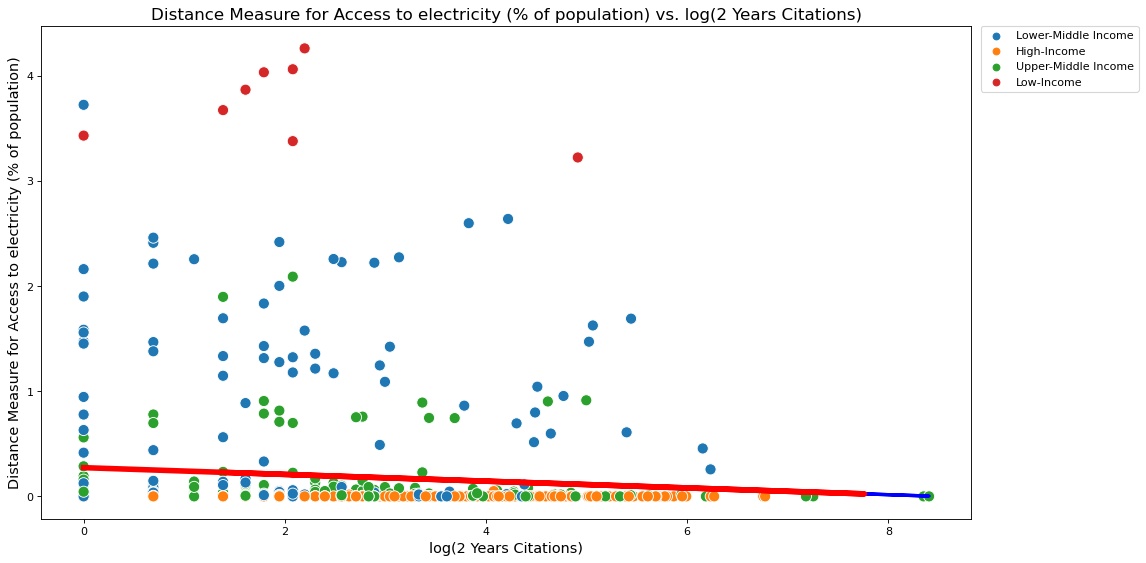

                            OLS Regression Results                            
Dep. Variable:            electricity   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     4.254
Date:                Thu, 22 Dec 2022   Prob (F-statistic):             0.0396
Time:                        05:56:40   Log-Likelihood:                -467.57
No. Observations:                 539   AIC:                             939.1
Df Residuals:                     537   BIC:                             947.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.2729      0.048      5.732      

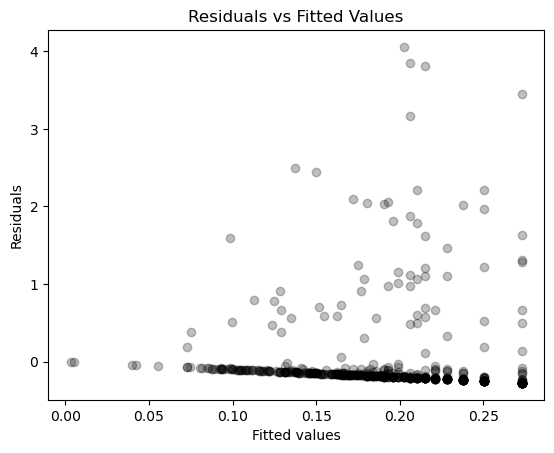

Residuals-- checking normality


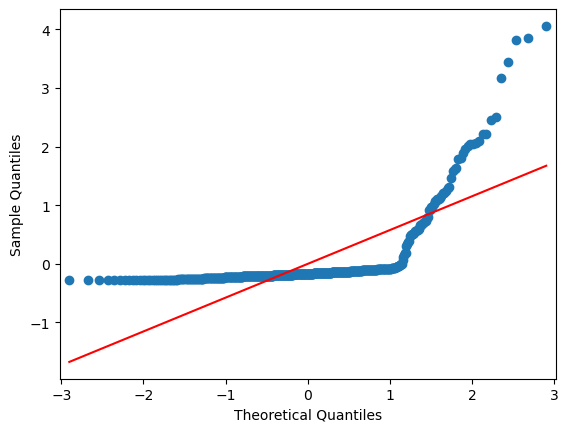

Residuals are not normal
rural_electricity vs log_2_Years


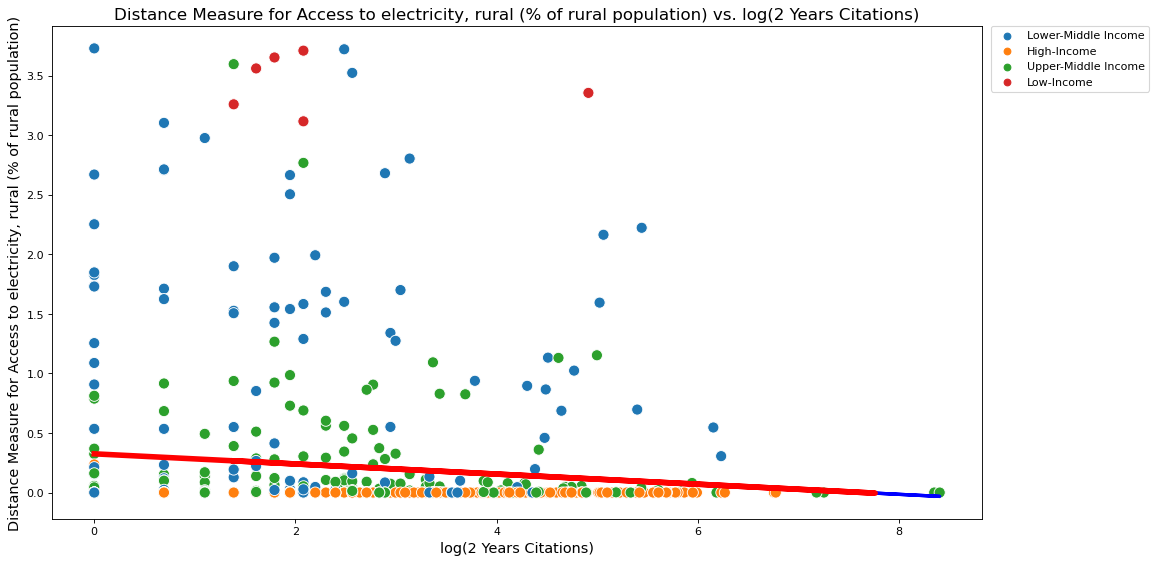

                            OLS Regression Results                            
Dep. Variable:      rural_electricity   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     6.744
Date:                Thu, 22 Dec 2022   Prob (F-statistic):            0.00966
Time:                        05:56:40   Log-Likelihood:                -490.95
No. Observations:                 536   AIC:                             985.9
Df Residuals:                     534   BIC:                             994.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.3250      0.050      6.498      

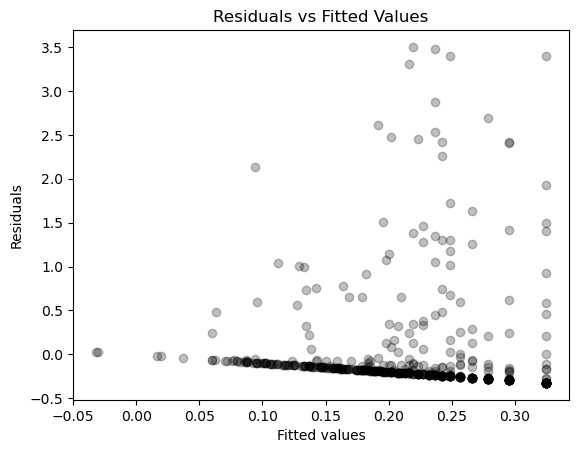

Residuals-- checking normality


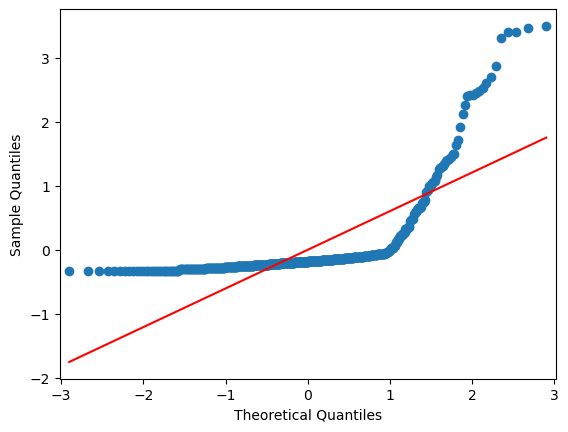

Residuals are not normal
urban_electricity vs log_2_Years


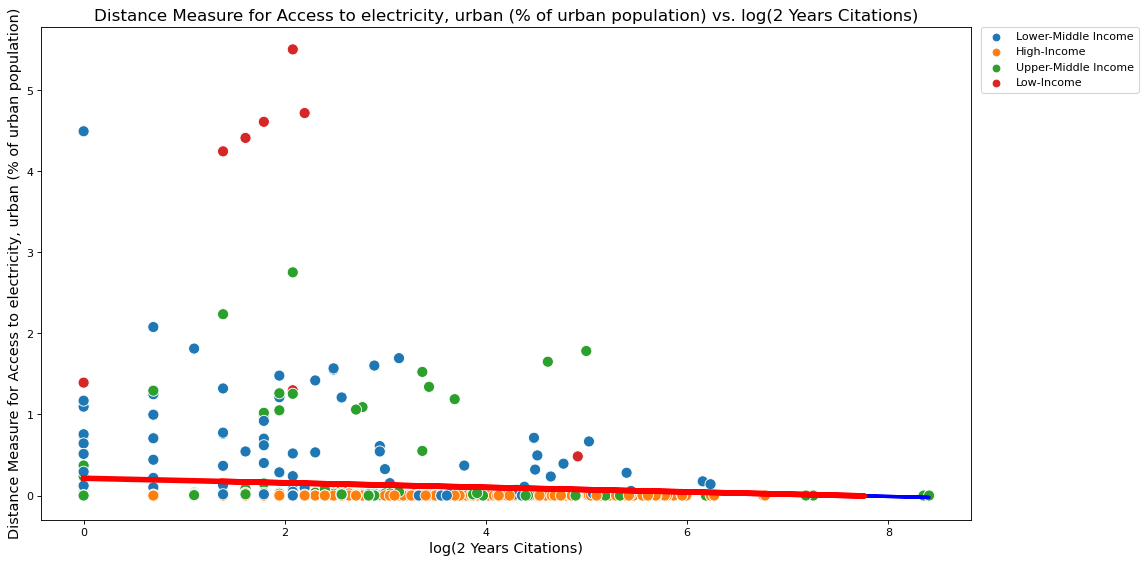

                            OLS Regression Results                            
Dep. Variable:      urban_electricity   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     3.942
Date:                Thu, 22 Dec 2022   Prob (F-statistic):             0.0476
Time:                        05:56:40   Log-Likelihood:                -413.36
No. Observations:                 537   AIC:                             830.7
Df Residuals:                     535   BIC:                             839.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.2132      0.043      4.936      

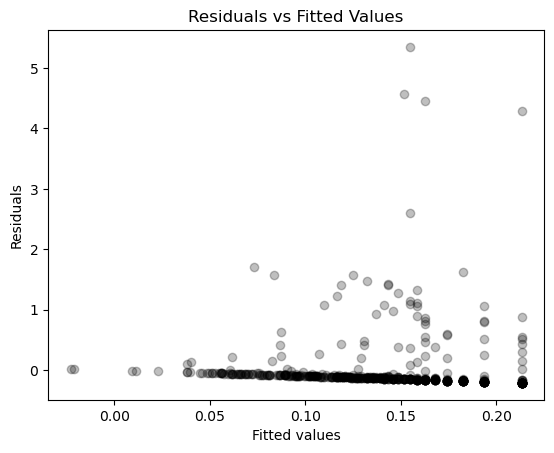

Residuals-- checking normality


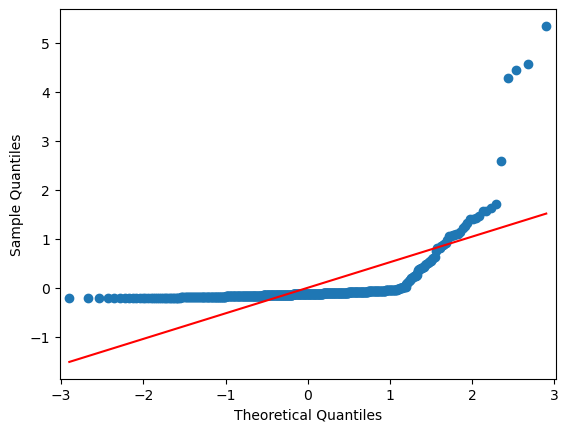

Residuals are not normal
Significant regression for:  [[], [], [], 'electricity', 'rural_electricity', 'urban_electricity', [], [], [], [], [], []]

Not significant regression for:  ['cooking', 'rural_cooking', 'urban_cooking', [], [], [], 'coal', 'oil_gas_coal', 'energy_use_kg_capita', 'fossil_fuel_consumption', 'renewable_output', 'renewable_consumption']

Residuals are not normal when the following indicators are plotted against log(2 years) [[], [], [], 'electricity', 'rural_electricity', 'urban_electricity', [], [], [], [], [], []]


In [66]:
warnings.filterwarnings("ignore")
indicators = data.columns.tolist()[4:16] #needs to be changed according to df
significant = []
not_significant = []
resid_not_norm_y = []
count = 0

for i in indicators:
    temp_df = data[['Year', 'Country Name', '2 years window', 'log_2_Years', 'Economy Level',i]]
    temp_df['log_2_Years'] = temp_df['log_2_Years'].astype(float)
    
    x_2_yrs_log = temp_df['log_2_Years']
    y_ind = temp_df[i]
    

    sig, not_sig, resids_not_normal = linear_regression_plot(x_2_yrs_log, y_ind, 'log_2_Years', i, temp_df, 'log(2 Years Citations)', ylabel_names[count])
    significant.append(sig)
    not_significant.append(not_sig)
    resid_not_norm_y.append(resids_not_normal)
    count += 1

print('Significant regression for: ',significant)
print()
print('Not significant regression for: ',not_significant)
print()
print('Residuals are not normal when the following indicators are plotted against log(2 years)', resid_not_norm_y)
warnings.filterwarnings("default")

In [67]:
if len(significant) - len(resid_not_norm_y) == 0:
    print("Residuals are not normal for any of the significant regressions")

Residuals are not normal for any of the significant regressions


##### Storing results in a data frame

In [68]:
significant_ind = [value for value in significant if value != []] 
val = len(significant_ind)

predictor = []
for i in range(val):
   predictor.append('log_2_years') 


is_significant = []
for i in range(val):
   is_significant.append('Yes') 

# is_not_significant = []
# for i in range(val):
#    is_not_significant.append('NA') 

models_sig = pd.DataFrame(list(zip(predictor, significant_ind, is_significant)),
               columns =['predictor','indicator', 'is_significant'])


not_significant_ind = [value for value in not_significant if value != []]
val = len(not_significant_ind)

predictor = []
for i in range(val):
   predictor.append('log_2_years') 


is_significant = []
for i in range(val):
   is_significant.append('No') 

# is_not_significant = []
# for i in range(val):
#    is_not_significant.append('yes') 

models_not_sig = pd.DataFrame(list(zip(predictor, not_significant_ind, is_significant)),
               columns =['predictor','indicator', 'is_significant'])

models = pd.concat([models_sig, models_not_sig],axis=0,ignore_index=True)
models

predictor                indicator is_significant
0   log_2_years              electricity            Yes
1   log_2_years        rural_electricity            Yes
2   log_2_years        urban_electricity            Yes
3   log_2_years                  cooking             No
4   log_2_years            rural_cooking             No
5   log_2_years            urban_cooking             No
6   log_2_years                     coal             No
7   log_2_years             oil_gas_coal             No
8   log_2_years     energy_use_kg_capita             No
9   log_2_years  fossil_fuel_consumption             No
10  log_2_years         renewable_output             No
11  log_2_years    renewable_consumption             No

#### - AR-index

electricity vs ar_index_ca


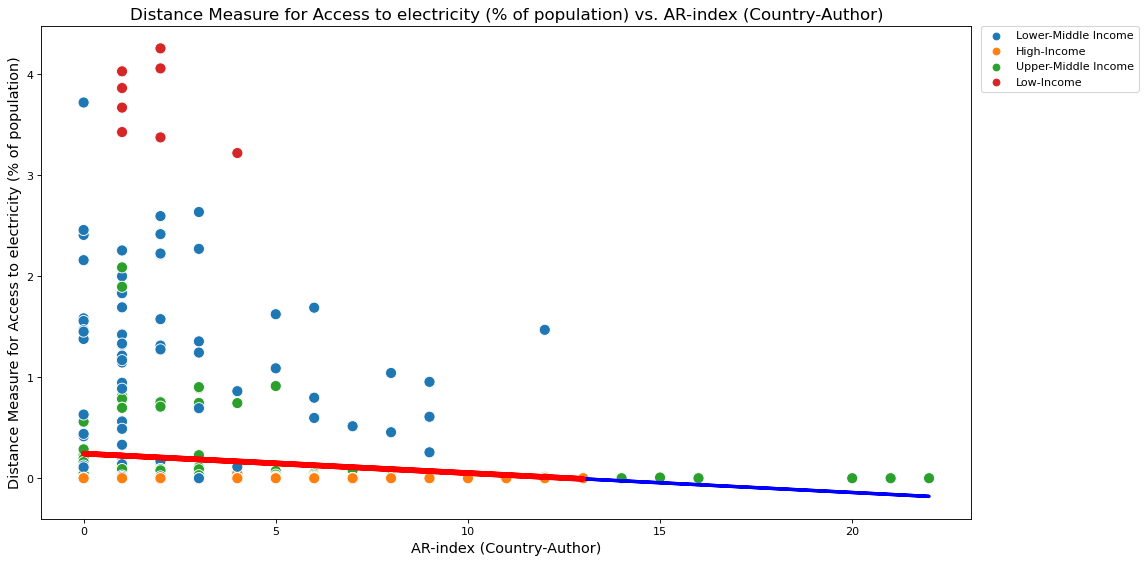

                            OLS Regression Results                            
Dep. Variable:            electricity   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     5.400
Date:                Thu, 22 Dec 2022   Prob (F-statistic):             0.0205
Time:                        05:56:41   Log-Likelihood:                -467.00
No. Observations:                 539   AIC:                             938.0
Df Residuals:                     537   BIC:                             946.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.2436      0.034      7.137      

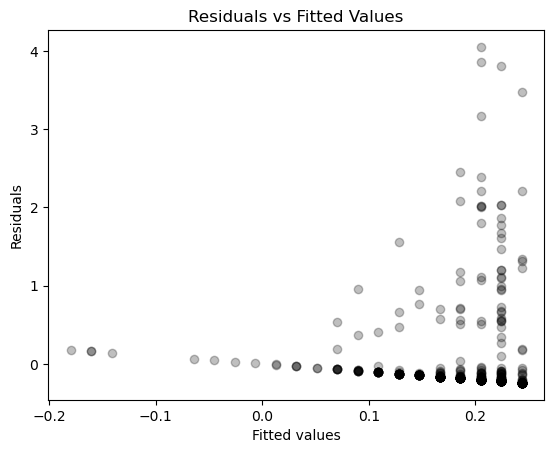

Residuals-- checking normality


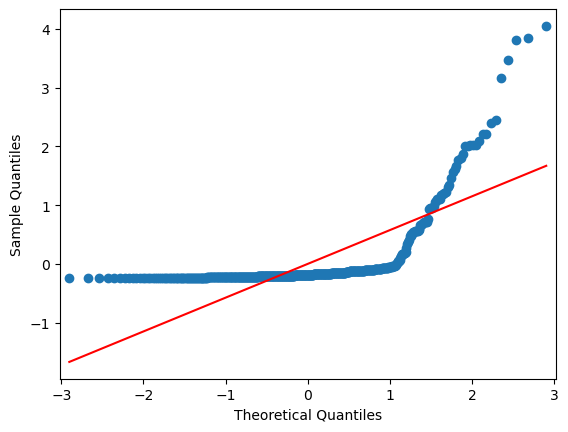

Residuals are not normal
rural_electricity vs ar_index_ca


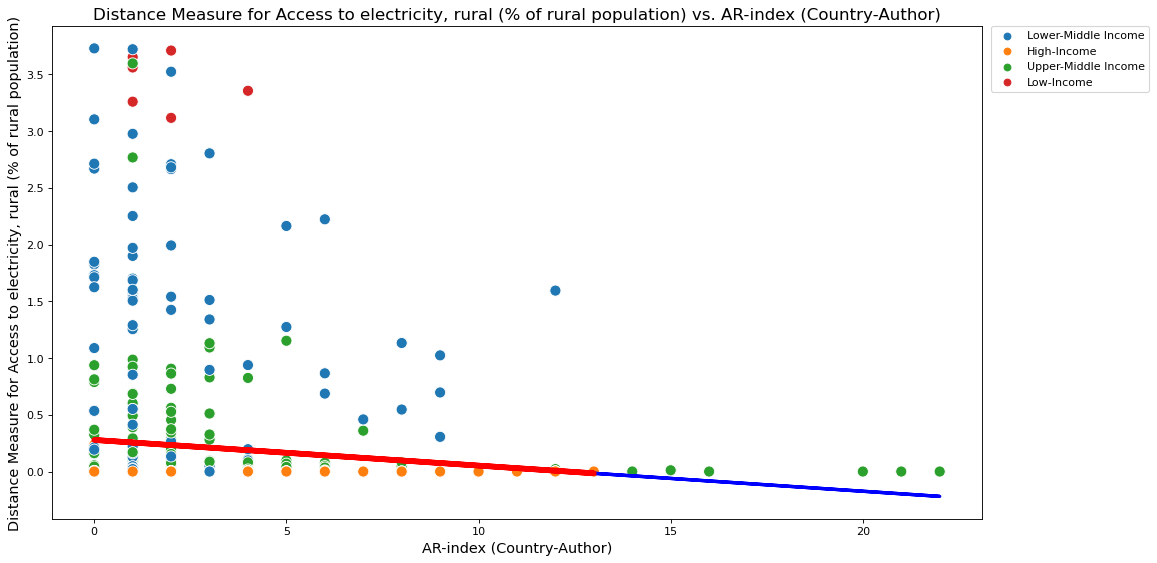

                            OLS Regression Results                            
Dep. Variable:      rural_electricity   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     6.738
Date:                Thu, 22 Dec 2022   Prob (F-statistic):            0.00970
Time:                        05:56:41   Log-Likelihood:                -490.95
No. Observations:                 536   AIC:                             985.9
Df Residuals:                     534   BIC:                             994.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.2782      0.036      7.742      

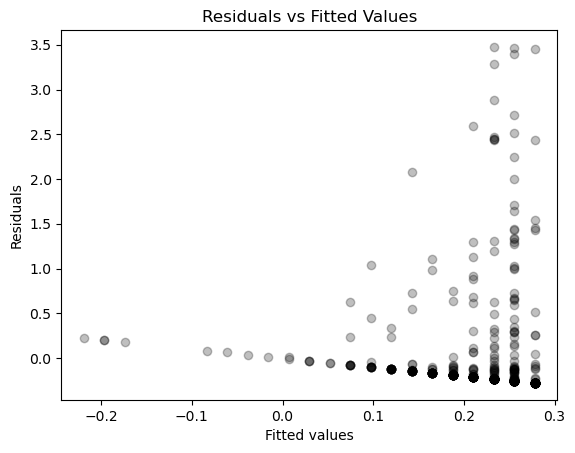

Residuals-- checking normality


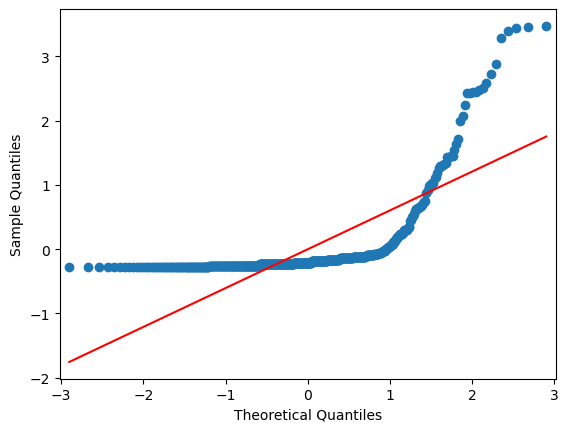

Residuals are not normal
urban_electricity vs ar_index_ca


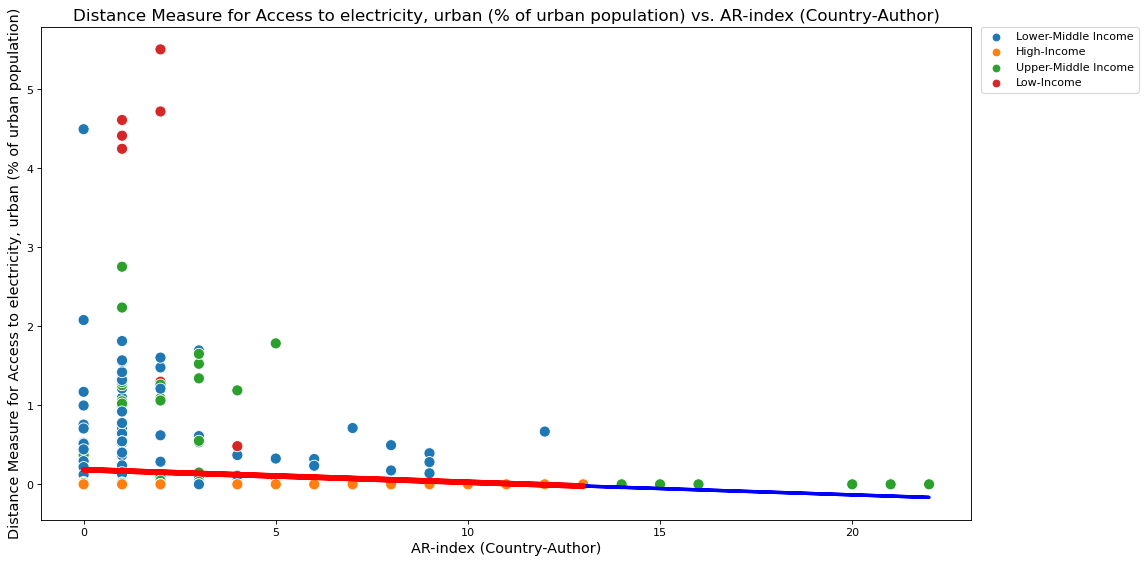

                            OLS Regression Results                            
Dep. Variable:      urban_electricity   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     4.494
Date:                Thu, 22 Dec 2022   Prob (F-statistic):             0.0345
Time:                        05:56:41   Log-Likelihood:                -413.09
No. Observations:                 537   AIC:                             830.2
Df Residuals:                     535   BIC:                             838.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1851      0.031      5.971      

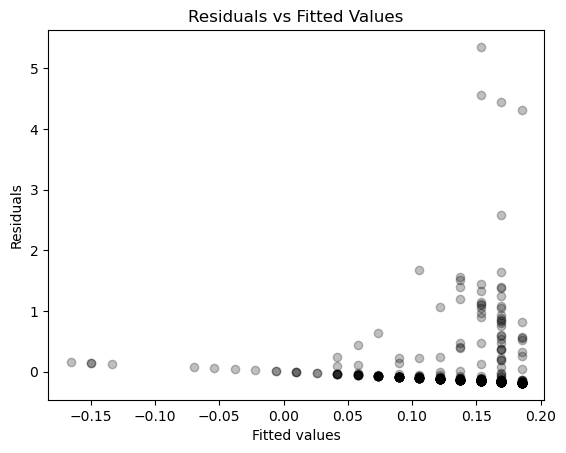

Residuals-- checking normality


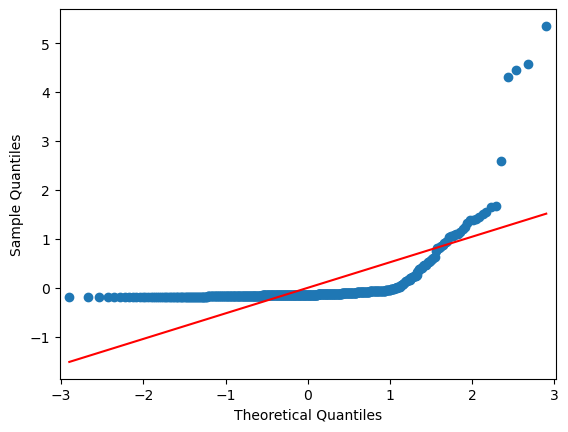

Residuals are not normal
renewable_consumption vs ar_index_ca


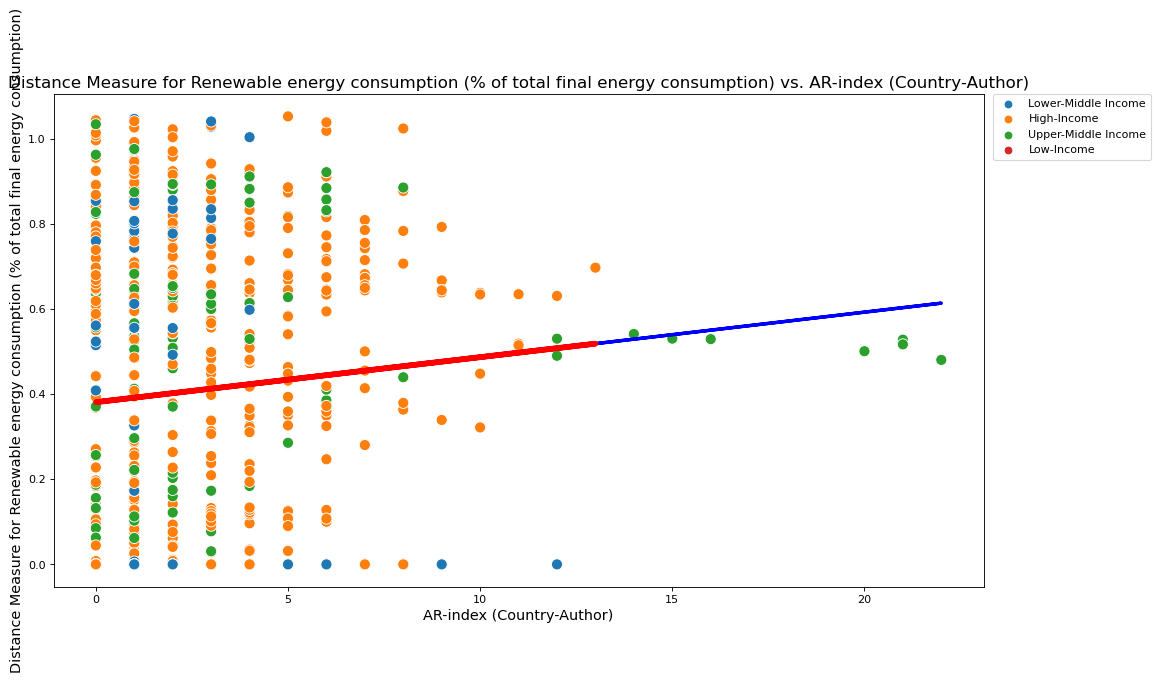

                              OLS Regression Results                             
Dep. Variable:     renewable_consumption   R-squared:                       0.008
Model:                               OLS   Adj. R-squared:                  0.006
Method:                    Least Squares   F-statistic:                     4.341
Date:                   Thu, 22 Dec 2022   Prob (F-statistic):             0.0377
Time:                           05:56:42   Log-Likelihood:                -203.70
No. Observations:                    540   AIC:                             411.4
Df Residuals:                        538   BIC:                             420.0
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.38

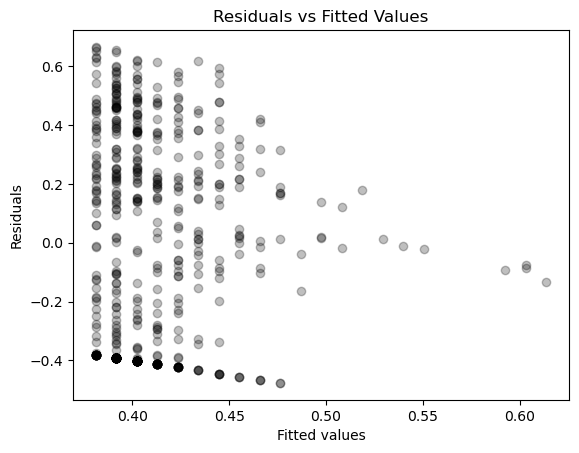

Residuals-- checking normality


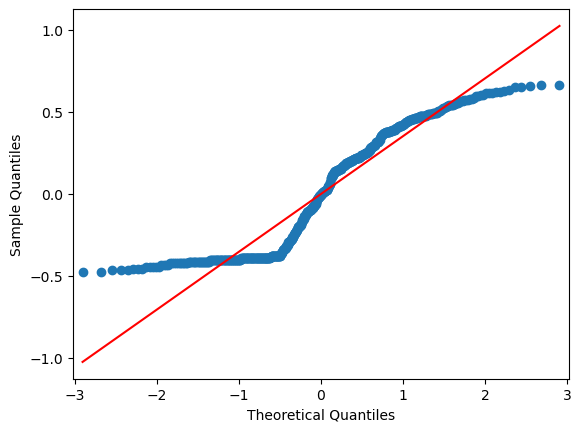

Residuals are not normal
Significant regression for:  [[], [], [], 'electricity', 'rural_electricity', 'urban_electricity', [], [], [], [], [], 'renewable_consumption']

Not significant regression for:  ['cooking', 'rural_cooking', 'urban_cooking', [], [], [], 'coal', 'oil_gas_coal', 'energy_use_kg_capita', 'fossil_fuel_consumption', 'renewable_output', []]

Residuals are not normal when the following indicators are plotted against AR-index [[], [], [], 'electricity', 'rural_electricity', 'urban_electricity', [], [], [], [], [], 'renewable_consumption']


In [69]:
warnings.filterwarnings("ignore")
indicators = data.columns.tolist()[4:16]
significant = []
not_significant = []
resid_not_norm_y = []
count = 0

for i in indicators:
    temp_df = data[['Year', 'Country Name', 'ar_index_ca', 'Economy Level',i]]
    temp_df['ar_index_ca'] = temp_df['ar_index_ca'].astype(int)
    
    ar_ind_bulk = temp_df['ar_index_ca']
    y_ind = temp_df[i]
    

    sig, not_sig, resids_not_normal = linear_regression_plot(ar_ind_bulk, y_ind, 'ar_index_ca', i, temp_df, 'AR-index (Country-Author)', ylabel_names[count])
    significant.append(sig)
    not_significant.append(not_sig)
    resid_not_norm_y.append(resids_not_normal)
    count += 1

print('Significant regression for: ',significant)
print()
print('Not significant regression for: ',not_significant)
print()
print('Residuals are not normal when the following indicators are plotted against AR-index', resid_not_norm_y)
warnings.filterwarnings("default")

In [70]:
if len(significant) - len(resid_not_norm_y) == 0:
    print("Residuals are not normal for any of the significant regressions")

Residuals are not normal for any of the significant regressions


##### Storing results in a data frame

In [71]:
significant_ind = [value for value in significant if value != []] 
val = len(significant_ind)

predictor = []
for i in range(val):
   predictor.append('AR-index') 


is_significant = []
for i in range(val):
   is_significant.append('Yes') 

# is_not_significant = []
# for i in range(val):
#    is_not_significant.append('NA') 

models_sig = pd.DataFrame(list(zip(predictor, significant_ind, is_significant)),
               columns =['predictor','indicator', 'is_significant'])


not_significant_ind = [value for value in not_significant if value != []]
val = len(not_significant_ind)

predictor = []
for i in range(val):
   predictor.append('AR-index') 


is_significant = []
for i in range(val):
   is_significant.append('No') 

# is_not_significant = []
# for i in range(val):
#    is_not_significant.append('yes') 

models_not_sig = pd.DataFrame(list(zip(predictor, not_significant_ind, is_significant)),
               columns =['predictor','indicator', 'is_significant'])

models = pd.concat([models_sig, models_not_sig],axis=0,ignore_index=True)
models

predictor                indicator is_significant
0   AR-index              electricity            Yes
1   AR-index        rural_electricity            Yes
2   AR-index        urban_electricity            Yes
3   AR-index    renewable_consumption            Yes
4   AR-index                  cooking             No
5   AR-index            rural_cooking             No
6   AR-index            urban_cooking             No
7   AR-index                     coal             No
8   AR-index             oil_gas_coal             No
9   AR-index     energy_use_kg_capita             No
10  AR-index  fossil_fuel_consumption             No
11  AR-index         renewable_output             No

### Quantile Regressions

#### - log_2_years












renewable_consumption vs log_2_Years


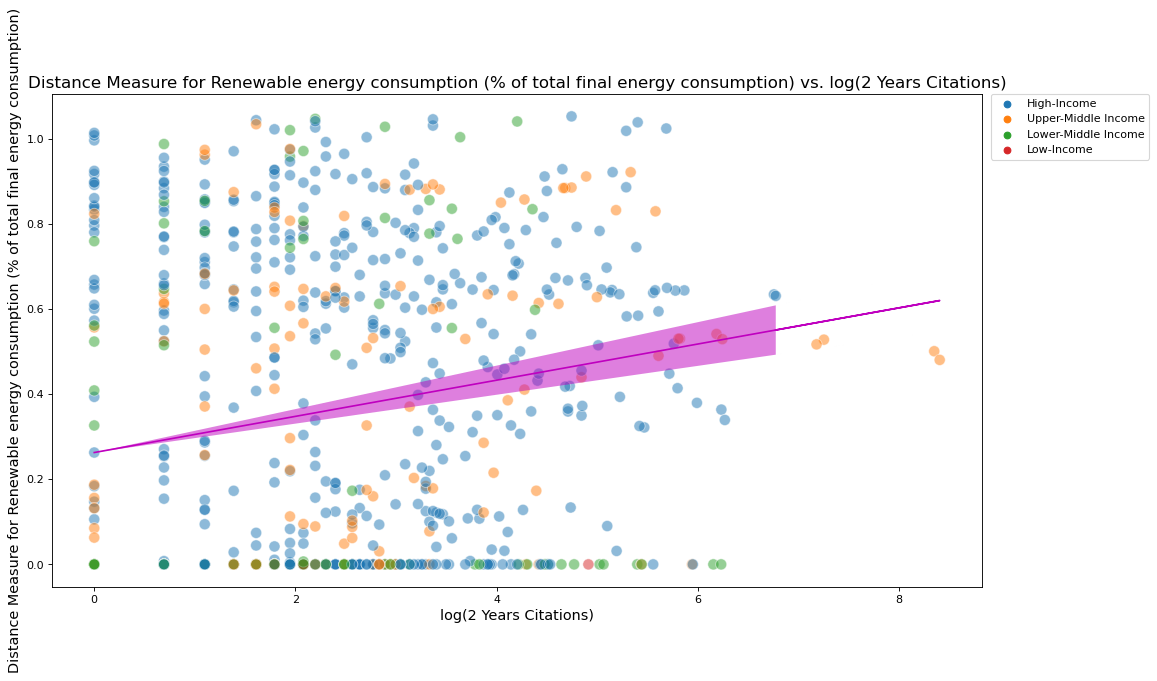

Average validation MSE over 5 folds:  0.12815563418642448

                           QuantReg Regression Results                           
Dep. Variable:     renewable_consumption   Pseudo R-squared:             0.008559
Model:                          QuantReg   Bandwidth:                      0.1907
Method:                    Least Squares   Sparsity:                        1.667
Date:                   Thu, 22 Dec 2022   No. Observations:                  757
Time:                           05:56:43   Df Residuals:                      755
                                           Df Model:                            1
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.2628      0.057      4.577      0.000       0.150       0.375
log_2_Years     0.0425      0.019      2.241      0.025       0.005       0.080


Significant regression for:  [[], [], [], [],

In [72]:
warnings.filterwarnings("ignore")
indicators = data.columns.tolist()[4:16] #needs to be changed according to df
significant = []
not_significant = []
resid_not_norm_y = []
count = 0

for i in indicators:
    temp_df = data[['Year', 'Country Name', '2 years window', 'log_2_Years', 'Economy Level',i]]
    temp_df['log_2_Years'] = temp_df['log_2_Years'].astype(float)
    
    x_2_yrs_log = temp_df['log_2_Years']
    y_ind = temp_df[i]

    sig, not_sig = QR_cv_with_CI(x_2_yrs_log, y_ind, 'log_2_Years', i, temp_df, 'log(2 Years Citations)', ylabel_names[count], 0.5)
    significant.append(sig)
    not_significant.append(not_sig)
    count += 1

print('Significant regression for: ',significant)
print()
print('Not significant regression for: ',not_significant)
print()
warnings.filterwarnings("default")

##### Storing results in a data frame

In [73]:
significant_ind = [value for value in significant if value != []] 
val = len(significant_ind)

predictor = []
for i in range(val):
   predictor.append('log_2_years') 


is_significant = []
for i in range(val):
   is_significant.append('Yes') 

# is_not_significant = []
# for i in range(val):
#    is_not_significant.append('NA') 

models_sig = pd.DataFrame(list(zip(predictor, significant_ind, is_significant)),
               columns =['predictor','indicator', 'is_significant'])


not_significant_ind = [value for value in not_significant if value != []]
val = len(not_significant_ind)

predictor = []
for i in range(val):
   predictor.append('log_2_years') 


is_significant = []
for i in range(val):
   is_significant.append('No') 

# is_not_significant = []
# for i in range(val):
#    is_not_significant.append('yes') 

models_not_sig = pd.DataFrame(list(zip(predictor, not_significant_ind, is_significant)),
               columns =['predictor','indicator', 'is_significant'])

models = pd.concat([models_sig, models_not_sig],axis=0,ignore_index=True)
models

predictor                indicator is_significant
0   log_2_years    renewable_consumption            Yes
1   log_2_years                  cooking             No
2   log_2_years            rural_cooking             No
3   log_2_years            urban_cooking             No
4   log_2_years              electricity             No
5   log_2_years        rural_electricity             No
6   log_2_years        urban_electricity             No
7   log_2_years                     coal             No
8   log_2_years             oil_gas_coal             No
9   log_2_years     energy_use_kg_capita             No
10  log_2_years  fossil_fuel_consumption             No
11  log_2_years         renewable_output             No

#### - AR-index

In [74]:
warnings.filterwarnings("ignore")
indicators = data.columns.tolist()[4:16]
significant = []
not_significant = []
resid_not_norm_y = []
count = 0

for i in indicators:
    temp_df = data[['Year', 'Country Name', 'ar_index_ca', 'Economy Level',i]]
    temp_df['ar_index_ca'] = temp_df['ar_index_ca'].astype(int)
    
    ar_ind_bulk = temp_df['ar_index_ca']
    y_ind = temp_df[i]

    sig, not_sig = QR_cv_with_CI(ar_ind_bulk, y_ind, 'ar_index_ca', i, temp_df, 'AR-index (Country-Author)', ylabel_names[count], 0.5)
    significant.append(sig)
    not_significant.append(not_sig)
    count += 1

print('Significant regression for: ',significant)
print()
print('Not significant regression for: ',not_significant)
print()
warnings.filterwarnings("default")













Significant regression for:  [[], [], [], [], [], [], [], [], [], [], [], []]

Not significant regression for:  ['cooking', 'rural_cooking', 'urban_cooking', 'electricity', 'rural_electricity', 'urban_electricity', 'coal', 'oil_gas_coal', 'energy_use_kg_capita', 'fossil_fuel_consumption', 'renewable_output', 'renewable_consumption']



##### Storing results in a data frame

In [75]:
significant_ind = [value for value in significant if value != []] 
val = len(significant_ind)

predictor = []
for i in range(val):
   predictor.append('AR-index') 


is_significant = []
for i in range(val):
   is_significant.append('yes') 

# is_not_significant = []
# for i in range(val):
#    is_not_significant.append('NA') 

models_sig = pd.DataFrame(list(zip(predictor, significant_ind, is_significant)),
               columns =['predictor','indicator', 'is_significant'])


not_significant_ind = [value for value in not_significant if value != []]
val = len(not_significant_ind)

predictor = []
for i in range(val):
   predictor.append('AR-index') 


is_significant = []
for i in range(val):
   is_significant.append('No') 

# is_not_significant = []
# for i in range(val):
#    is_not_significant.append('yes') 

models_not_sig = pd.DataFrame(list(zip(predictor, not_significant_ind, is_significant)),
               columns =['predictor','indicator', 'is_significant'])

models = pd.concat([models_sig, models_not_sig],axis=0,ignore_index=True)
models

predictor                indicator is_significant
0   AR-index                  cooking             No
1   AR-index            rural_cooking             No
2   AR-index            urban_cooking             No
3   AR-index              electricity             No
4   AR-index        rural_electricity             No
5   AR-index        urban_electricity             No
6   AR-index                     coal             No
7   AR-index             oil_gas_coal             No
8   AR-index     energy_use_kg_capita             No
9   AR-index  fossil_fuel_consumption             No
10  AR-index         renewable_output             No
11  AR-index    renewable_consumption             No

In [76]:
# # data = pd.read_csv('data/indicators_citations_bulk_df.csv')
# data = pd.read_csv('data/dist_calc_citations_bulk_df.csv')
# # data = pd.read_csv('data/pc_change_citations_bulk_df.csv')
# income = pd.read_csv('data/wdi_incomelevels.csv')

# #all zeros for citations were dropped in building the data frame
# data['log_2_Years'] = np.log(data['2 years window'])

# #merge with income
# income['Country'] = income['Country'].str.lower()
# income = income.rename(columns={'Country': 'Country Name'})
# data = pd.merge(data, income, on=['Country Name'], how='left') 

# #change column names to prevent patsy error issue with quantile regression
# data = data.rename(columns={'energy_use(kg/capita)': 'energy_use_kg_capita'})
# data = data.rename(columns={'energy_use(kg/kGDP)': 'energy_use_kg_kgdp'})
# data = data.rename(columns={'GDP/Energy(constrant_2017)': 'gdp_over_energy_const_2017'}) 
# data = data.rename(columns={'GDP/Energy': 'gdp_over_energy'})
# data = data.rename(columns={'ar index bulk': 'ar_index_bulk'})
# data.head(4)

## Only OECD countries

In [77]:
##oecd

# data = pd.read_csv('data/indicators_citations_bulk_df.csv')
data = pd.read_csv('data/dist_calc_oecd_citations_ca_df.csv')
cols = data.columns[0]
data = data.drop(columns = cols)
# data = pd.read_csv('data/pc_change_citations_bulk_df.csv')
income = pd.read_csv('data/wdi_incomelevels.csv')

#all zeros for citations were dropped in building the data frame
data['log_2_Years'] = np.log(data['2 years window'])

#merge with income
income['Country'] = income['Country'].str.lower()
income = income.rename(columns={'Country': 'Country Name'})
data = pd.merge(data, income, on=['Country Name'], how='left') 

#change column names to prevent patsy error issue with quantile regression
data = data.rename(columns={'electricy': 'electricity'})
data = data.rename(columns={'urban_electricy': 'urban_electricity'})
data = data.rename(columns={'rural_electricy': 'rural_electricity'})
data = data.rename(columns={'electric_from_renuable': 'electric_from_renewable'})
data = data.rename(columns={'energy_use(kg/capita)': 'energy_use_kg_capita'})
data = data.rename(columns={'energy_use(kg/kGDP)': 'energy_use_kg_kgdp'})
data = data.rename(columns={'GDP/Energy(constrant_2017)': 'gdp_over_energy_const_2017'})
data = data.rename(columns={'fossil_fual_comsumption': 'fossil_fuel_consumption'}) 
data = data.rename(columns={'renewable_comsumption': 'renewable_consumption'})
data = data.rename(columns={'GDP/Energy': 'gdp_over_energy'})

data = data.rename(columns={'ar index ca': 'ar_index_ca'})
data.head(4)

Year    Country Name  2 years window  ar_index_ca  cooking  rural_cooking  \
0  1991           india             1.0     0.707107      NaN            NaN   
1  1991  united kingdom             5.0     0.516398      NaN            NaN   
2  1992          brazil             2.0     0.454859      NaN            NaN   
3  1994           china             1.0     0.192450      NaN            NaN   

   urban_cooking  electricity  rural_electricity  urban_electricity  coal  \
0            NaN          NaN                NaN                NaN   NaN   
1            NaN          NaN                NaN                NaN   NaN   
2            NaN          NaN                NaN                NaN   NaN   
3            NaN          NaN                NaN                NaN   NaN   

   oil_gas_coal  energy_use_kg_capita  fossil_fuel_consumption  \
0           NaN                   NaN                      NaN   
1           NaN                   NaN                      NaN   
2           NaN                   NaN                      NaN   
3           NaN                   NaN                      NaN   

   renewable_output  renewable_consumption  log_2_Years        Economy Level  
0               NaN                    NaN     0.000000  Lower-Middle Income  
1               NaN                    NaN     1.609438          High-Income  
2               NaN                    NaN     0.693147  Upper-Middle Income  
3               NaN                    NaN     0.000000  Upper-Middle Income

### Simple Linear Regressions

#### - log_2_years

energy_use_kg_capita vs log_2_Years


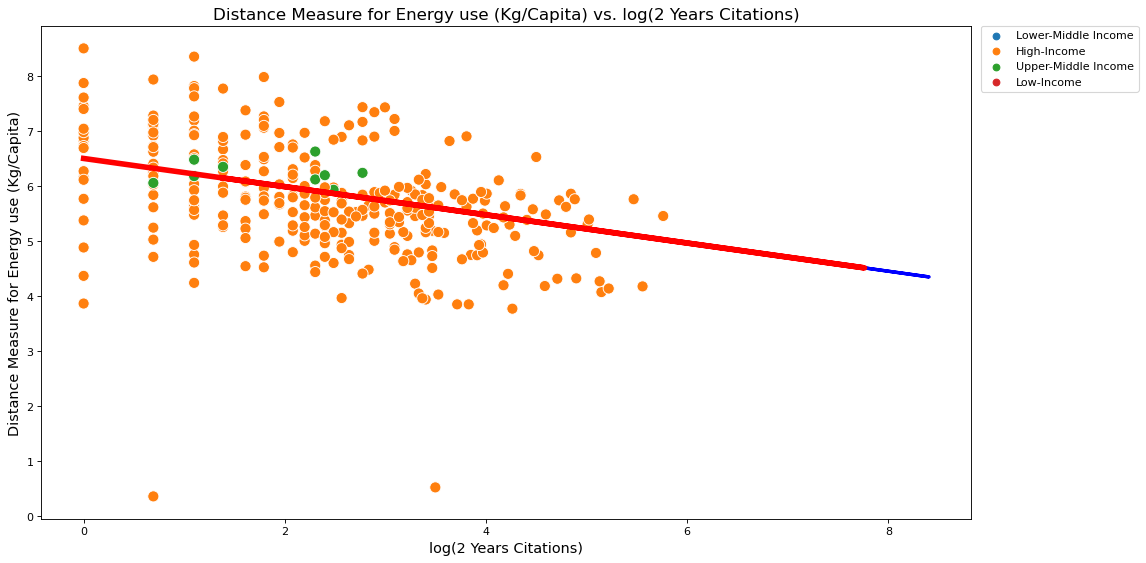

                             OLS Regression Results                             
Dep. Variable:     energy_use_kg_capita   R-squared:                       0.108
Model:                              OLS   Adj. R-squared:                  0.104
Method:                   Least Squares   F-statistic:                     29.45
Date:                  Thu, 22 Dec 2022   Prob (F-statistic):           1.38e-07
Time:                          05:56:44   Log-Likelihood:                -352.80
No. Observations:                   246   AIC:                             709.6
Df Residuals:                       244   BIC:                             716.6
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           6.5033      0.

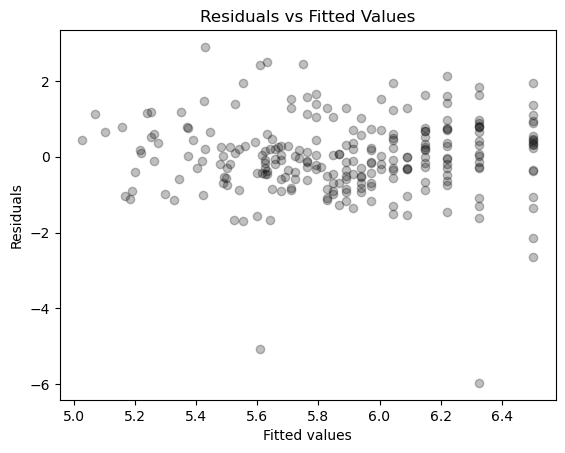

Residuals-- checking normality


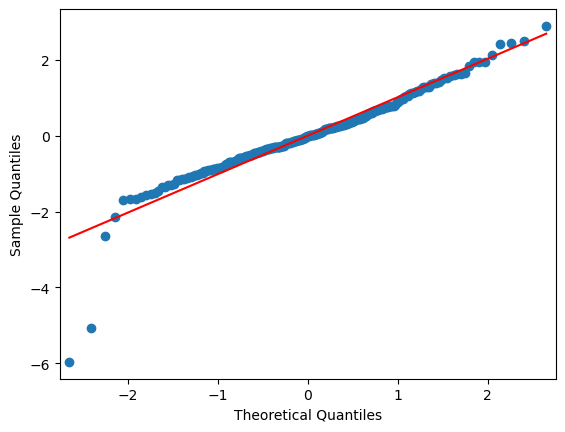

Residuals are not normal
Significant regression for:  [[], [], [], [], [], [], [], [], 'energy_use_kg_capita', [], [], []]

Not significant regression for:  ['cooking', 'rural_cooking', 'urban_cooking', 'electricity', 'rural_electricity', 'urban_electricity', 'coal', 'oil_gas_coal', [], 'fossil_fuel_consumption', 'renewable_output', 'renewable_consumption']

Residuals are not normal when the following indicators are plotted against log(2 years) [[], [], [], [], [], [], [], [], 'energy_use_kg_capita', [], [], []]


In [78]:
warnings.filterwarnings("ignore")
indicators = data.columns.tolist()[4:16] #needs to be changed according to df
significant = []
not_significant = []
resid_not_norm_y = []
count = 0

for i in indicators:
    temp_df = data[['Year', 'Country Name', '2 years window', 'log_2_Years', 'Economy Level',i]]
    temp_df['log_2_Years'] = temp_df['log_2_Years'].astype(float)
    
    x_2_yrs_log = temp_df['log_2_Years']
    y_ind = temp_df[i]
    

    sig, not_sig, resids_not_normal = linear_regression_plot(x_2_yrs_log, y_ind, 'log_2_Years', i, temp_df, 'log(2 Years Citations)', ylabel_names[count])
    significant.append(sig)
    not_significant.append(not_sig)
    resid_not_norm_y.append(resids_not_normal)
    
    count += 1

print('Significant regression for: ',significant)
print()
print('Not significant regression for: ',not_significant)
print()
print('Residuals are not normal when the following indicators are plotted against log(2 years)', resid_not_norm_y)
warnings.filterwarnings("default")

In [79]:
if len(significant) - len(resid_not_norm_y) == 0:
    print("Residuals are not normal for any of the significant regressions")

Residuals are not normal for any of the significant regressions


##### Storing results in a data frame

In [80]:
significant_ind = [value for value in significant if value != []] 
val = len(significant_ind)

predictor = []
for i in range(val):
   predictor.append('log_2_years') 


is_significant = []
for i in range(val):
   is_significant.append('Yes') 

# is_not_significant = []
# for i in range(val):
#    is_not_significant.append('NA') 

models_sig = pd.DataFrame(list(zip(predictor, significant_ind, is_significant)),
               columns =['predictor','indicator', 'is_significant'])


not_significant_ind = [value for value in not_significant if value != []]
val = len(not_significant_ind)

predictor = []
for i in range(val):
   predictor.append('log_2_years') 


is_significant = []
for i in range(val):
   is_significant.append('No') 

# is_not_significant = []
# for i in range(val):
#    is_not_significant.append('yes') 

models_not_sig = pd.DataFrame(list(zip(predictor, not_significant_ind, is_significant)),
               columns =['predictor','indicator', 'is_significant'])

models = pd.concat([models_sig, models_not_sig],axis=0,ignore_index=True)
models

predictor                indicator is_significant
0   log_2_years     energy_use_kg_capita            Yes
1   log_2_years                  cooking             No
2   log_2_years            rural_cooking             No
3   log_2_years            urban_cooking             No
4   log_2_years              electricity             No
5   log_2_years        rural_electricity             No
6   log_2_years        urban_electricity             No
7   log_2_years                     coal             No
8   log_2_years             oil_gas_coal             No
9   log_2_years  fossil_fuel_consumption             No
10  log_2_years         renewable_output             No
11  log_2_years    renewable_consumption             No

#### - AR-index

energy_use_kg_capita vs ar_index_ca


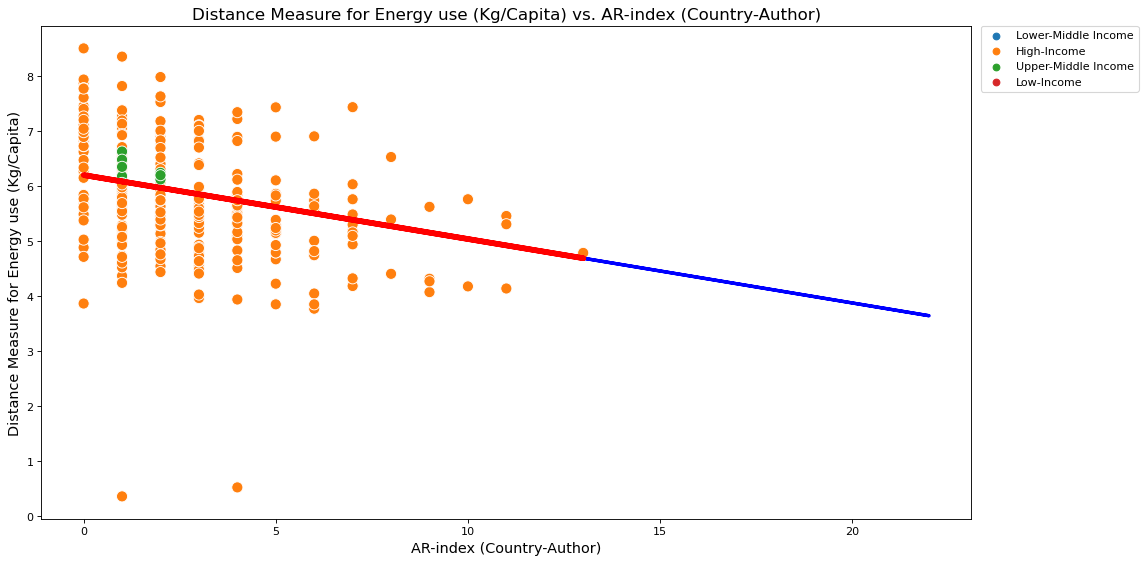

                             OLS Regression Results                             
Dep. Variable:     energy_use_kg_capita   R-squared:                       0.072
Model:                              OLS   Adj. R-squared:                  0.068
Method:                   Least Squares   F-statistic:                     18.97
Date:                  Thu, 22 Dec 2022   Prob (F-statistic):           1.96e-05
Time:                          05:56:45   Log-Likelihood:                -357.61
No. Observations:                   246   AIC:                             719.2
Df Residuals:                       244   BIC:                             726.2
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           6.2014      0.

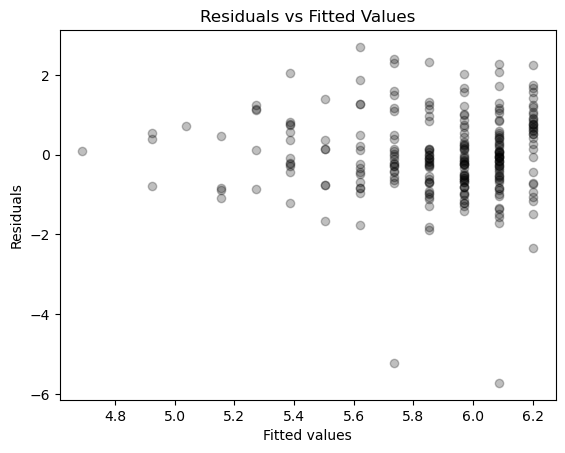

Residuals-- checking normality


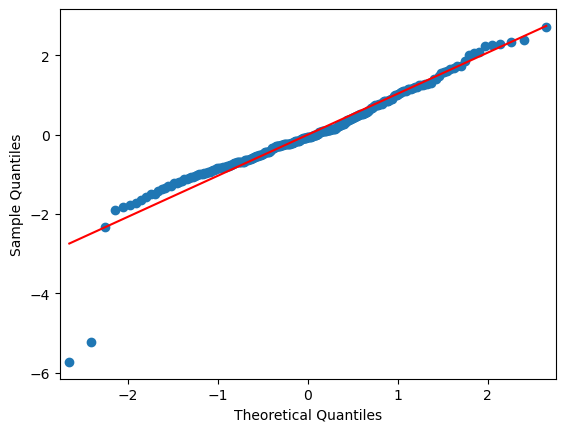

Residuals are not normal
Significant regression for:  [[], [], [], [], [], [], [], [], 'energy_use_kg_capita', [], [], []]

Not significant regression for:  ['cooking', 'rural_cooking', 'urban_cooking', 'electricity', 'rural_electricity', 'urban_electricity', 'coal', 'oil_gas_coal', [], 'fossil_fuel_consumption', 'renewable_output', 'renewable_consumption']

Residuals are not normal when the following indicators are plotted against AR-index [[], [], [], [], [], [], [], [], 'energy_use_kg_capita', [], [], []]


In [81]:
warnings.filterwarnings("ignore")
indicators = data.columns.tolist()[4:16]
significant = []
not_significant = []
resid_not_norm_y = []
count = 0

for i in indicators:
    temp_df = data[['Year', 'Country Name', 'ar_index_ca', 'Economy Level',i]]
    temp_df['ar_index_ca'] = temp_df['ar_index_ca'].astype(int)
    
    ar_ind_bulk = temp_df['ar_index_ca']
    y_ind = temp_df[i]
    

    sig, not_sig, resids_not_normal = linear_regression_plot(ar_ind_bulk, y_ind, 'ar_index_ca', i, temp_df, 'AR-index (Country-Author)', ylabel_names[count])
    significant.append(sig)
    not_significant.append(not_sig)
    resid_not_norm_y.append(resids_not_normal)
    count += 1

print('Significant regression for: ',significant)
print()
print('Not significant regression for: ',not_significant)
print()
print('Residuals are not normal when the following indicators are plotted against AR-index', resid_not_norm_y)
warnings.filterwarnings("default")

In [82]:
if len(significant) - len(resid_not_norm_y) == 0:
    print("Residuals are not normal for any of the significant regressions")

Residuals are not normal for any of the significant regressions


##### Storing results in a data frame

In [83]:
significant_ind = [value for value in significant if value != []] 
val = len(significant_ind)

predictor = []
for i in range(val):
   predictor.append('AR-index') 


is_significant = []
for i in range(val):
   is_significant.append('Yes') 

# is_not_significant = []
# for i in range(val):
#    is_not_significant.append('NA') 

models_sig = pd.DataFrame(list(zip(predictor, significant_ind, is_significant)),
               columns =['predictor','indicator', 'is_significant'])


not_significant_ind = [value for value in not_significant if value != []]
val = len(not_significant_ind)

predictor = []
for i in range(val):
   predictor.append('AR-index') 


is_significant = []
for i in range(val):
   is_significant.append('No') 

# is_not_significant = []
# for i in range(val):
#    is_not_significant.append('yes') 

models_not_sig = pd.DataFrame(list(zip(predictor, not_significant_ind, is_significant)),
               columns =['predictor','indicator', 'is_significant'])

models = pd.concat([models_sig, models_not_sig],axis=0,ignore_index=True)
models

predictor                indicator is_significant
0   AR-index     energy_use_kg_capita            Yes
1   AR-index                  cooking             No
2   AR-index            rural_cooking             No
3   AR-index            urban_cooking             No
4   AR-index              electricity             No
5   AR-index        rural_electricity             No
6   AR-index        urban_electricity             No
7   AR-index                     coal             No
8   AR-index             oil_gas_coal             No
9   AR-index  fossil_fuel_consumption             No
10  AR-index         renewable_output             No
11  AR-index    renewable_consumption             No

### Quantile Regressions

#### - log_2_years

cooking vs log_2_Years


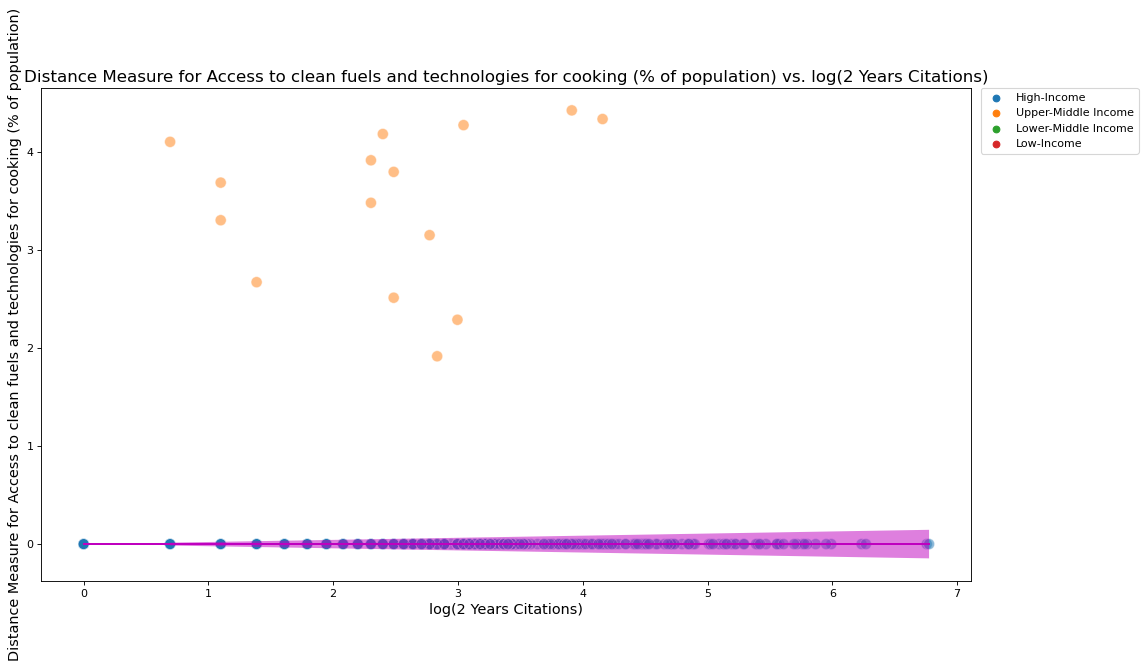

Average validation MSE over 5 folds:  0.48799344091164265

                         QuantReg Regression Results                          
Dep. Variable:                cooking   Pseudo R-squared:           -7.917e-07
Model:                       QuantReg   Bandwidth:                   7.037e-08
Method:                 Least Squares   Sparsity:                    7.414e-07
Date:                Thu, 22 Dec 2022   No. Observations:                  430
Time:                        05:56:45   Df Residuals:                      428
                                        Df Model:                            1
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -2.358e-08    3.8e-08     -0.621      0.535   -9.82e-08     5.1e-08
log_2_Years   6.64e-08    1.2e-08      5.520      0.000    4.28e-08       9e-08


rural_cooking vs log_2_Years


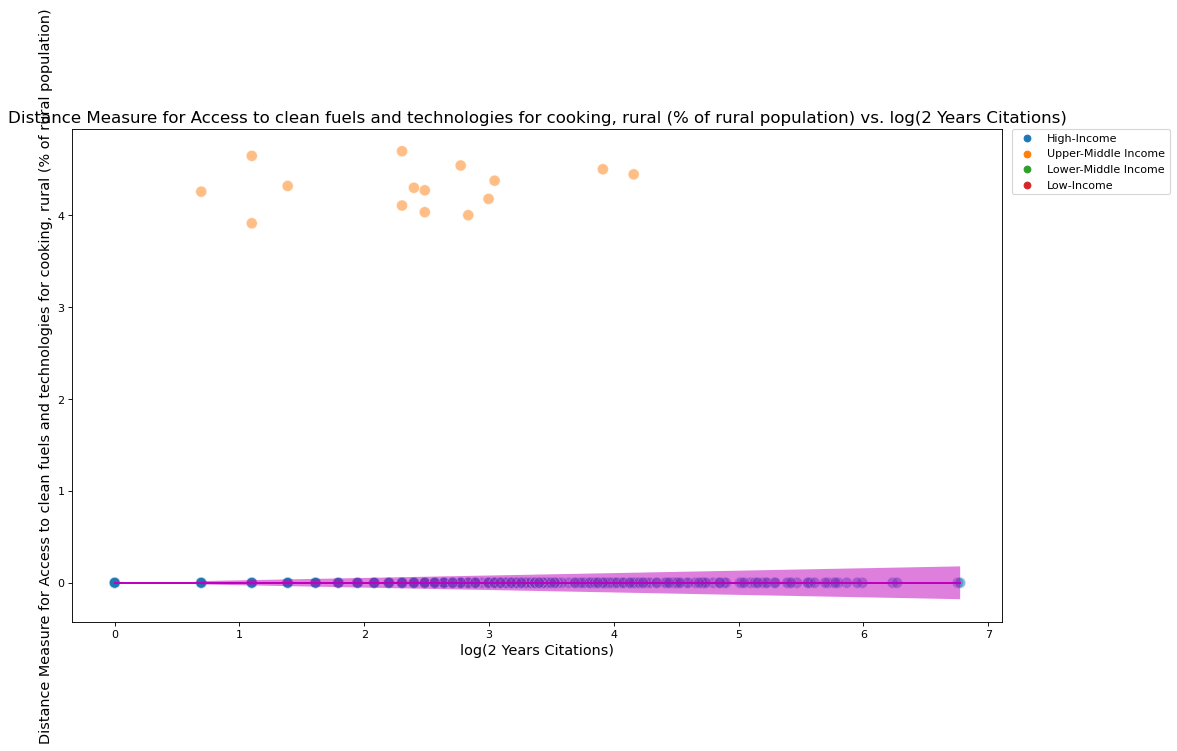

Average validation MSE over 5 folds:  0.7366524650982054

                         QuantReg Regression Results                          
Dep. Variable:          rural_cooking   Pseudo R-squared:           -7.970e-07
Model:                       QuantReg   Bandwidth:                   9.361e-08
Method:                 Least Squares   Sparsity:                    8.849e-07
Date:                Thu, 22 Dec 2022   No. Observations:                  430
Time:                        05:56:45   Df Residuals:                      428
                                        Df Model:                            1
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -4.018e-08   4.53e-08     -0.887      0.376   -1.29e-07    4.89e-08
log_2_Years  8.833e-08   1.44e-08      6.152      0.000    6.01e-08    1.17e-07


urban_cooking vs log_2_Years


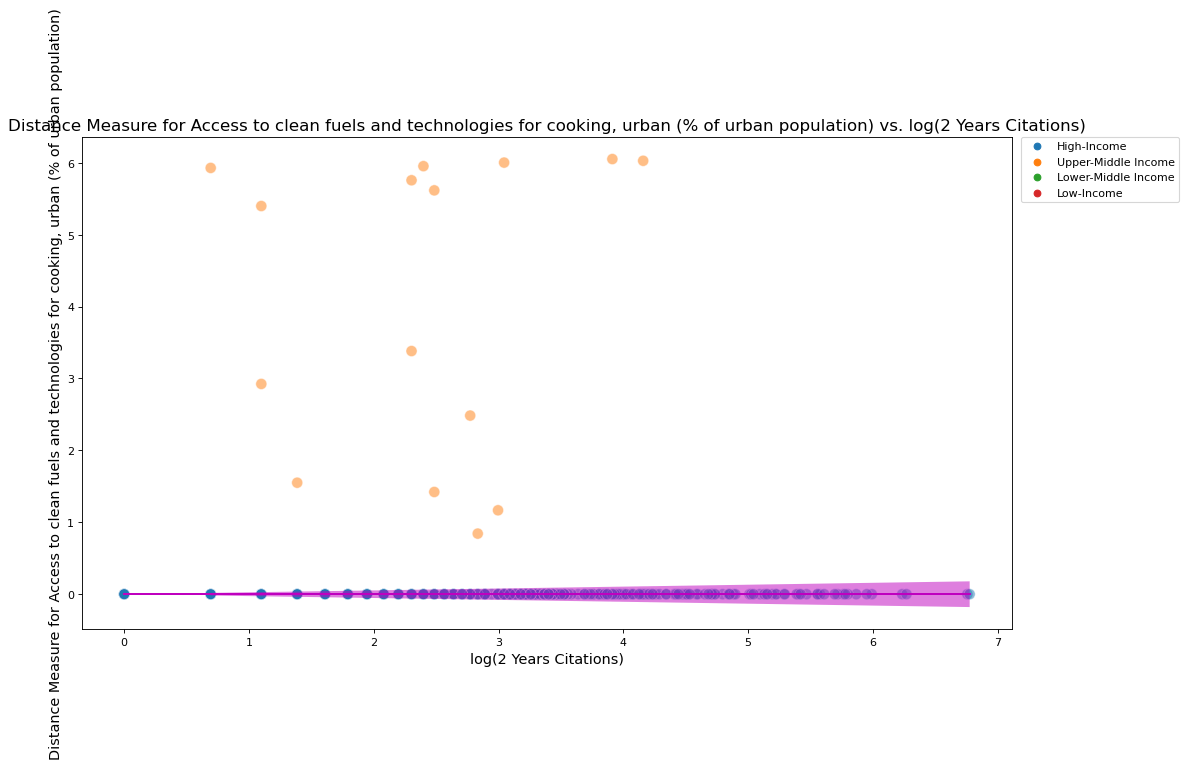

Average validation MSE over 5 folds:  0.7294062223764136

                         QuantReg Regression Results                          
Dep. Variable:          urban_cooking   Pseudo R-squared:           -8.196e-07
Model:                       QuantReg   Bandwidth:                   7.739e-08
Method:                 Least Squares   Sparsity:                    7.849e-07
Date:                Thu, 22 Dec 2022   No. Observations:                  430
Time:                        05:56:45   Df Residuals:                      428
                                        Df Model:                            1
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    -2.82e-08   4.02e-08     -0.702      0.483   -1.07e-07    5.08e-08
log_2_Years  7.302e-08   1.27e-08      5.734      0.000     4.8e-08    9.81e-08







energy_use_kg_capita vs log_2_Years


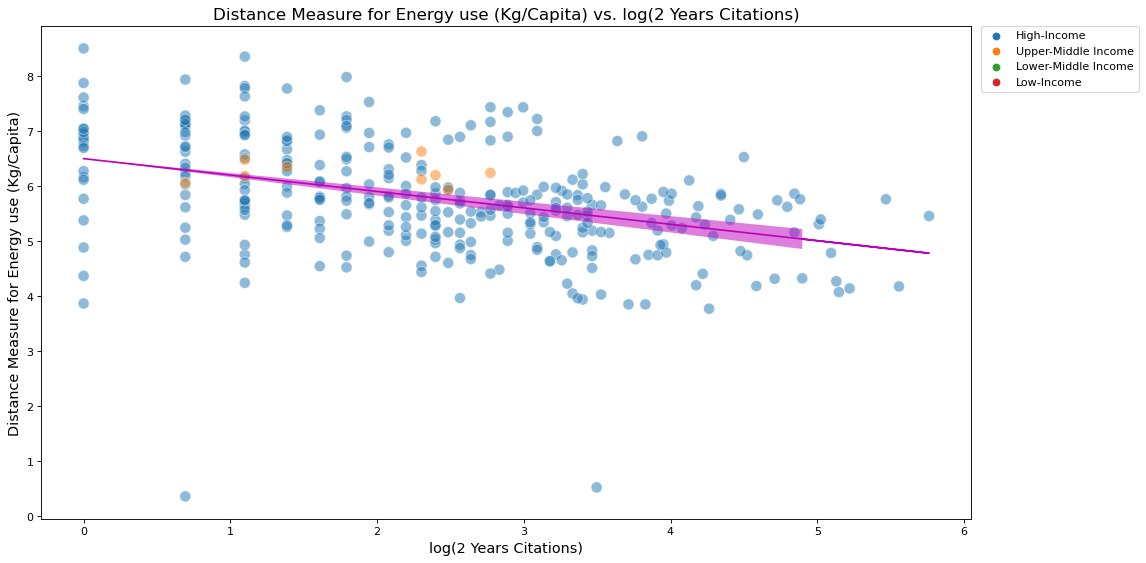

Average validation MSE over 5 folds:  0.9509663286814407

                          QuantReg Regression Results                           
Dep. Variable:     energy_use_kg_capita   Pseudo R-squared:              0.07756
Model:                         QuantReg   Bandwidth:                      0.5756
Method:                   Least Squares   Sparsity:                        2.112
Date:                  Thu, 22 Dec 2022   No. Observations:                  355
Time:                          05:56:46   Df Residuals:                      353
                                          Df Model:                            1
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       6.5000      0.114     56.808      0.000       6.275       6.725
log_2_Years    -0.2983      0.041     -7.193      0.000      -0.380      -0.217





Significant regression for:  ['cooking', 'rural_co

In [84]:
warnings.filterwarnings("ignore")
indicators = data.columns.tolist()[4:16] #needs to be changed according to df
significant = []
not_significant = []
resid_not_norm_y = []
count = 0

for i in indicators:
    temp_df = data[['Year', 'Country Name', '2 years window', 'log_2_Years', 'Economy Level',i]]
    temp_df['log_2_Years'] = temp_df['log_2_Years'].astype(float)
    
    x_2_yrs_log = temp_df['log_2_Years']
    y_ind = temp_df[i]

    sig, not_sig = QR_cv_with_CI(x_2_yrs_log, y_ind, 'log_2_Years', i, temp_df, 'log(2 Years Citations)', ylabel_names[count], 0.5)
    significant.append(sig)
    not_significant.append(not_sig)
    count += 1

print('Significant regression for: ',significant)
print()
print('Not significant regression for: ',not_significant)
print()
warnings.filterwarnings("default")

In [85]:
if len(significant) - len(resid_not_norm_y) == 0:
    print("Residuals are not normal for any of the significant regressions")

##### Storing results in a data frame

In [86]:
significant_ind = [value for value in significant if value != []] 
val = len(significant_ind)

predictor = []
for i in range(val):
   predictor.append('log_2_years') 


is_significant = []
for i in range(val):
   is_significant.append('Yes') 

# is_not_significant = []
# for i in range(val):
#    is_not_significant.append('NA') 

models_sig = pd.DataFrame(list(zip(predictor, significant_ind, is_significant)),
               columns =['predictor','indicator', 'is_significant'])


not_significant_ind = [value for value in not_significant if value != []]
val = len(not_significant_ind)

predictor = []
for i in range(val):
   predictor.append('log_2_years') 


is_significant = []
for i in range(val):
   is_significant.append('No') 

# is_not_significant = []
# for i in range(val):
#    is_not_significant.append('yes') 

models_not_sig = pd.DataFrame(list(zip(predictor, not_significant_ind, is_significant)),
               columns =['predictor','indicator', 'is_significant'])

models = pd.concat([models_sig, models_not_sig],axis=0,ignore_index=True)
models

predictor                indicator is_significant
0   log_2_years                  cooking            Yes
1   log_2_years            rural_cooking            Yes
2   log_2_years            urban_cooking            Yes
3   log_2_years     energy_use_kg_capita            Yes
4   log_2_years              electricity             No
5   log_2_years        rural_electricity             No
6   log_2_years        urban_electricity             No
7   log_2_years                     coal             No
8   log_2_years             oil_gas_coal             No
9   log_2_years  fossil_fuel_consumption             No
10  log_2_years         renewable_output             No
11  log_2_years    renewable_consumption             No

#### - AR-index

cooking vs ar_index_ca


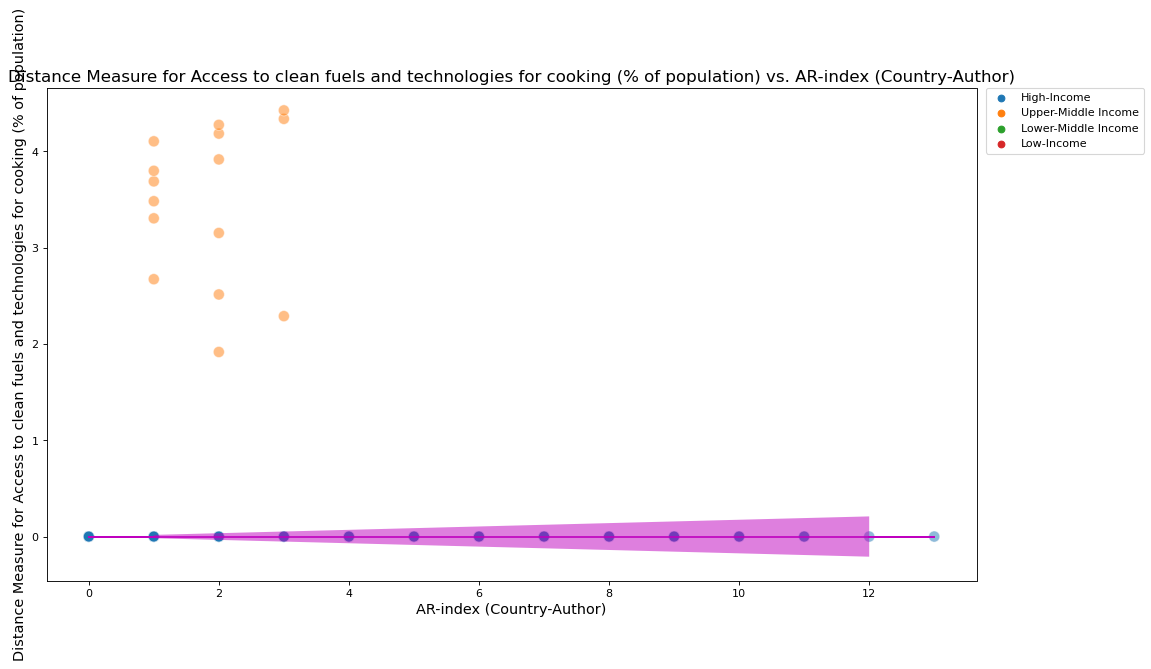

Average validation MSE over 5 folds:  0.487993435062377

                         QuantReg Regression Results                          
Dep. Variable:                cooking   Pseudo R-squared:           -6.928e-07
Model:                       QuantReg   Bandwidth:                   6.273e-08
Method:                 Least Squares   Sparsity:                    6.370e-07
Date:                Thu, 22 Dec 2022   No. Observations:                  430
Time:                        05:56:46   Df Residuals:                      428
                                        Df Model:                            1
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    1.459e-08   2.44e-08      0.598      0.550   -3.33e-08    6.25e-08
ar_index_ca  4.265e-08   6.26e-09      6.813      0.000    3.03e-08     5.5e-08


rural_cooking vs ar_index_ca


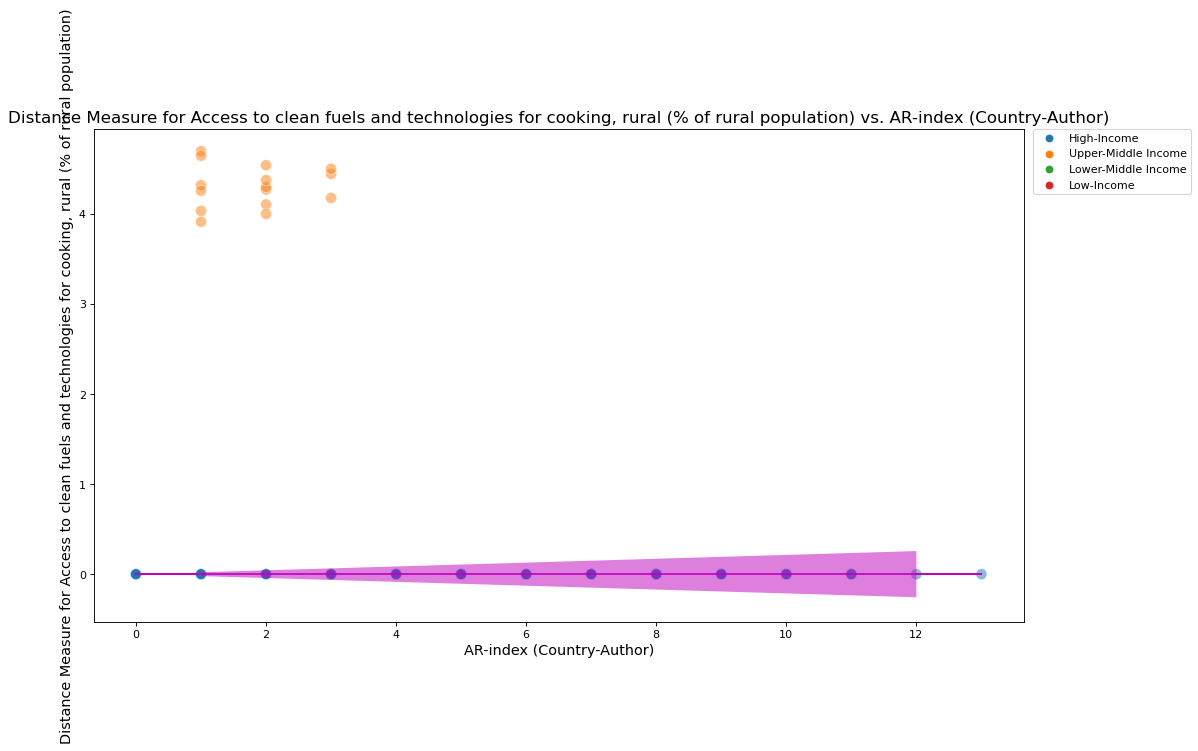

Average validation MSE over 5 folds:  0.7366524580700411

                         QuantReg Regression Results                          
Dep. Variable:          rural_cooking   Pseudo R-squared:           -7.003e-07
Model:                       QuantReg   Bandwidth:                   8.932e-08
Method:                 Least Squares   Sparsity:                    5.853e-07
Date:                Thu, 22 Dec 2022   No. Observations:                  430
Time:                        05:56:46   Df Residuals:                      428
                                        Df Model:                            1
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    1.655e-09   2.24e-08      0.074      0.941   -4.24e-08    4.57e-08
ar_index_ca  6.073e-08   5.75e-09     10.557      0.000    4.94e-08     7.2e-08


urban_cooking vs ar_index_ca


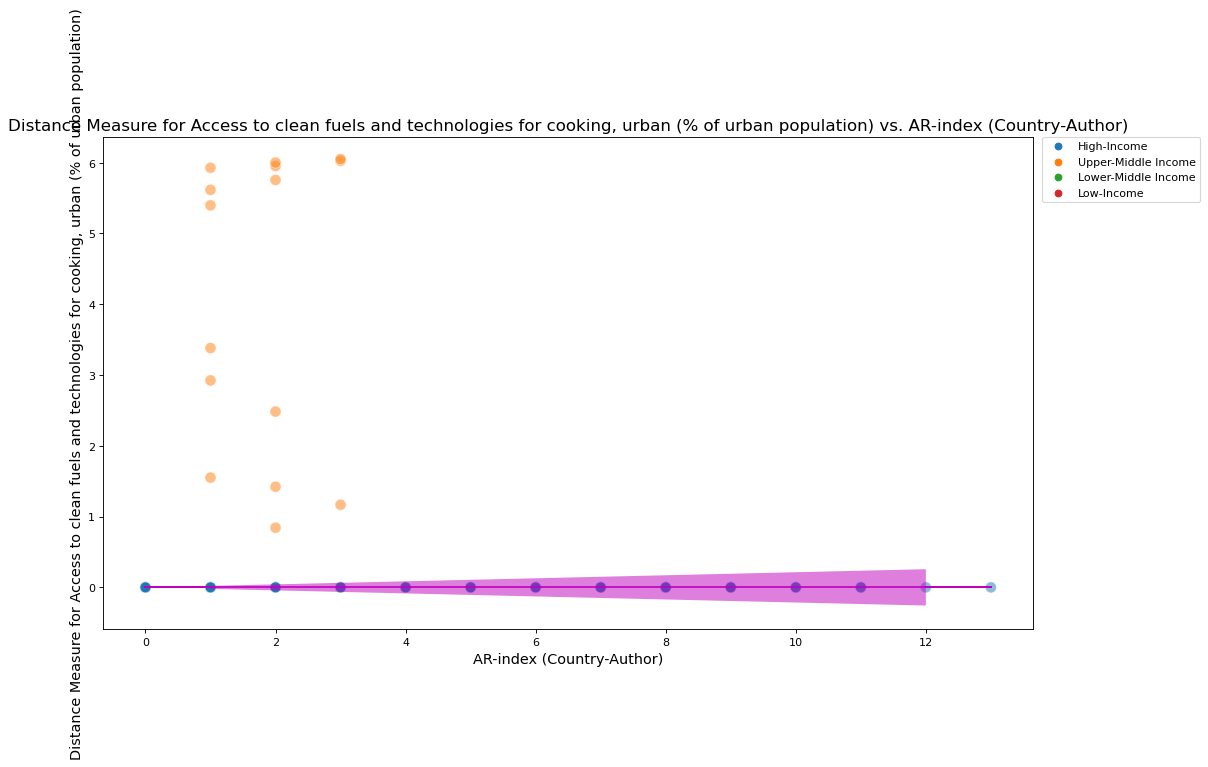

Average validation MSE over 5 folds:  0.7294062238101651

                         QuantReg Regression Results                          
Dep. Variable:          urban_cooking   Pseudo R-squared:           -5.742e-07
Model:                       QuantReg   Bandwidth:                   4.874e-08
Method:                 Least Squares   Sparsity:                    8.270e-07
Date:                Thu, 22 Dec 2022   No. Observations:                  430
Time:                        05:56:47   Df Residuals:                      428
                                        Df Model:                            1
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    2.433e-08   3.16e-08      0.769      0.442   -3.79e-08    8.65e-08
ar_index_ca  3.314e-08   8.13e-09      4.077      0.000    1.72e-08    4.91e-08



rural_electricity vs ar_index_ca


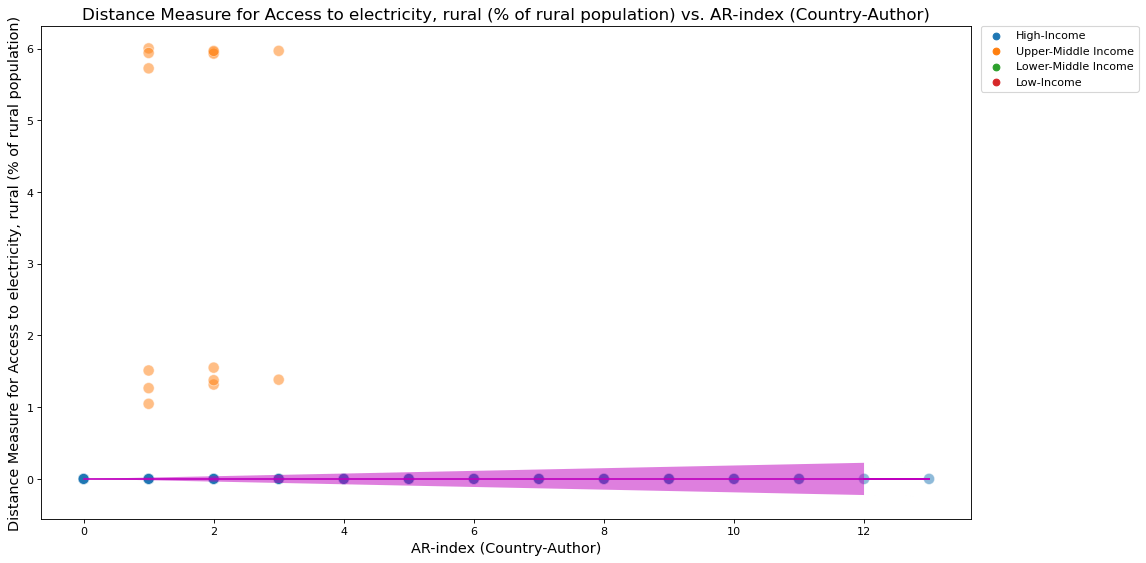

Average validation MSE over 5 folds:  0.5766180430652623

                         QuantReg Regression Results                          
Dep. Variable:      rural_electricity   Pseudo R-squared:           -2.734e-07
Model:                       QuantReg   Bandwidth:                   9.554e-09
Method:                 Least Squares   Sparsity:                    2.418e-07
Date:                Thu, 22 Dec 2022   No. Observations:                  450
Time:                        05:56:47   Df Residuals:                      448
                                        Df Model:                            1
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    5.171e-08    8.9e-09      5.812      0.000    3.42e-08    6.92e-08
ar_index_ca -6.599e-09   2.33e-09     -2.832      0.005   -1.12e-08   -2.02e-09





energy_use_kg_capita vs ar_index_ca


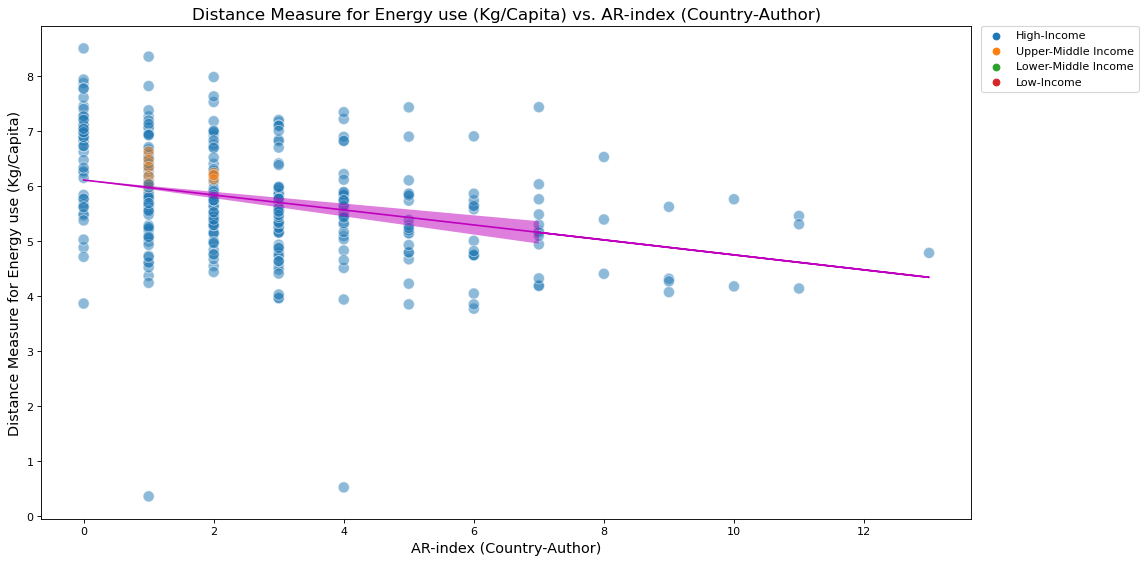

Average validation MSE over 5 folds:  0.9938487798766145

                          QuantReg Regression Results                           
Dep. Variable:     energy_use_kg_capita   Pseudo R-squared:              0.04355
Model:                         QuantReg   Bandwidth:                      0.6371
Method:                   Least Squares   Sparsity:                        2.235
Date:                  Thu, 22 Dec 2022   No. Observations:                  355
Time:                          05:56:47   Df Residuals:                      353
                                          Df Model:                            1
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       6.1115      0.091     67.441      0.000       5.933       6.290
ar_index_ca    -0.1361      0.025     -5.411      0.000      -0.186      -0.087





Significant regression for:  ['cooking', 'rural_co

In [87]:
warnings.filterwarnings("ignore")
indicators = data.columns.tolist()[4:16]
significant = []
not_significant = []
resid_not_norm_y = []
count = 0

for i in indicators:
    temp_df = data[['Year', 'Country Name', 'ar_index_ca', 'Economy Level',i]]
    temp_df['ar_index_ca'] = temp_df['ar_index_ca'].astype(int)
    
    ar_ind_bulk = temp_df['ar_index_ca']
    y_ind = temp_df[i]
    
    sig, not_sig = QR_cv_with_CI(ar_ind_bulk, y_ind, 'ar_index_ca', i, temp_df, 'AR-index (Country-Author)', ylabel_names[count], 0.5)
    significant.append(sig)
    not_significant.append(not_sig)
    count += 1

print('Significant regression for: ',significant)
print()
print('Not significant regression for: ',not_significant)
print()
warnings.filterwarnings("default")

In [88]:
if len(significant) - len(resid_not_norm_y) == 0:
    print("Residuals are not normal for any of the significant regressions")

##### Storing results in a data frame

In [89]:
significant_ind = [value for value in significant if value != []] 
val = len(significant_ind)

predictor = []
for i in range(val):
   predictor.append('AR-index') 


is_significant = []
for i in range(val):
   is_significant.append('yes') 

# is_not_significant = []
# for i in range(val):
#    is_not_significant.append('NA') 

models_sig = pd.DataFrame(list(zip(predictor, significant_ind, is_significant)),
               columns =['predictor','indicator', 'is_significant'])


not_significant_ind = [value for value in not_significant if value != []]
val = len(not_significant_ind)

predictor = []
for i in range(val):
   predictor.append('AR-index') 


is_significant = []
for i in range(val):
   is_significant.append('No') 

# is_not_significant = []
# for i in range(val):
#    is_not_significant.append('yes') 

models_not_sig = pd.DataFrame(list(zip(predictor, not_significant_ind, is_significant)),
               columns =['predictor','indicator', 'is_significant'])

models = pd.concat([models_sig, models_not_sig],axis=0,ignore_index=True)
models

predictor                indicator is_significant
0   AR-index                  cooking            yes
1   AR-index            rural_cooking            yes
2   AR-index            urban_cooking            yes
3   AR-index        rural_electricity            yes
4   AR-index     energy_use_kg_capita            yes
5   AR-index              electricity             No
6   AR-index        urban_electricity             No
7   AR-index                     coal             No
8   AR-index             oil_gas_coal             No
9   AR-index  fossil_fuel_consumption             No
10  AR-index         renewable_output             No
11  AR-index    renewable_consumption             No